In [34]:
# Import libraries

import os
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from IPython.display import display
from sklearn.model_selection import train_test_split
import xgboost as xgb
import sklearn.tree as tree
from sklearn.metrics import roc_auc_score
from sklearn.metrics import r2_score
from sklearn.metrics import roc_curve
import scipy.stats.stats as stat

In [2]:
# set max number of rows to diplay in panadas output

pd.set_option('display.max_rows', 1000)

In [3]:
# create folder for outputs

try:
    os.mkdir('output')
    print('Created sucessfully') 
except FileExistsError:
    print('Already exists')

Already exists


In [4]:
#Define functions

# Define function for plotting variable distribution
def plot_dist(vars):
    for x in vars:    
        fig, ax = plt.subplots(figsize=(6, 6))
        plot = sns.distplot(df[x].fillna(-99), kde=False, ax=ax)
        plt.show()
        plot.get_figure().savefig('output/' + x + '_dist.png')
    return

# Define function for plotting variable x default rate
def plot_def_rate(vars, target, n):

    N = n

    for v in vars:
        temp = df[[v,target]].fillna(-99).sort_values(by = v, ascending = True).reset_index(drop = True)
        x = np.convolve(temp[v], np.ones((N,))/N, mode='valid')
        x2 = list(temp.index)[:-N+1]
        y = np.convolve(temp[target], np.ones((N,))/N, mode='valid')
        fig, ax = plt.subplots(figsize=(6, 6))
        plot = sns.lineplot(x[::N],y[::N], ax=ax)
        plt.show()
        plot.get_figure().savefig('output/' + v + '_def_rate_by_value.png')
        print(v, '- by value')
        fig, ax = plt.subplots(figsize=(6, 6))
        plot = sns.lineplot(x2[::N],y[::N], ax=ax)
        plt.show()
        plot.get_figure().savefig('output/' + v + '_def_rate_by_index.png')
        print(v, '- by index')
        print('-'*40)
    return

# Calculate univariate auc with decision tree model
def uni_auc(vars ,target, tree_depth, tree_max_node, tree_min_leaf):
    varlist = []
    auclist = []
    for v in vars:
        tree_model = tree.DecisionTreeClassifier(max_depth = tree_depth, 
                                                 max_leaf_nodes = tree_max_node, 
                                                 min_samples_leaf = tree_min_leaf)
        tree_model.fit(X = df[[v]], y = df[target])
        tree_output = tree_model.predict_proba(df[[v]])[:,1]
        auc = roc_auc_score(df[target], tree_output)
        varlist.append(v)
        auclist.append(auc)
    output = pd.DataFrame()
    output['variable'] = varlist
    output['auc'] = auclist
    return output

In [5]:
# read data from csv file

df = pd.read_csv('cs-training.csv').iloc[:, 1:]

In [6]:
# check data has imported as expected

print(df.dtypes)
print('-'*40)
df.head()

SeriousDlqin2yrs                          int64
RevolvingUtilizationOfUnsecuredLines    float64
age                                       int64
NumberOfTime30-59DaysPastDueNotWorse      int64
DebtRatio                               float64
MonthlyIncome                           float64
NumberOfOpenCreditLinesAndLoans           int64
NumberOfTimes90DaysLate                   int64
NumberRealEstateLoansOrLines              int64
NumberOfTime60-89DaysPastDueNotWorse      int64
NumberOfDependents                      float64
dtype: object
----------------------------------------


SeriousDlqin2yrs  RevolvingUtilizationOfUnsecuredLines  age  \
0                 1                              0.766127   45   
1                 0                              0.957151   40   
2                 0                              0.658180   38   
3                 0                              0.233810   30   
4                 0                              0.907239   49   

   NumberOfTime30-59DaysPastDueNotWorse  DebtRatio  MonthlyIncome  \
0                                     2   0.802982         9120.0   
1                                     0   0.121876         2600.0   
2                                     1   0.085113         3042.0   
3                                     0   0.036050         3300.0   
4                                     1   0.024926        63588.0   

   NumberOfOpenCreditLinesAndLoans  NumberOfTimes90DaysLate  \
0                               13                        0   
1                                4                        0   
2                                2                        1   
3                                5                        0   
4                                7                        0   

   NumberRealEstateLoansOrLines  NumberOfTime60-89DaysPastDueNotWorse  \
0                             6                                     0   
1                             0                                     0   
2                             0                                     0   
3                             0                                     0   
4                             1                                     0   

   NumberOfDependents  
0                 2.0  
1                 1.0  
2                 0.0  
3                 0.0  
4                 0.0

In [7]:
# Define list of column names

col_names = df.columns.sort_values()
col_target = df.columns[0]
col_vars = df.columns[1:].sort_values()

list(col_vars)

['DebtRatio',
 'MonthlyIncome',
 'NumberOfDependents',
 'NumberOfOpenCreditLinesAndLoans',
 'NumberOfTime30-59DaysPastDueNotWorse',
 'NumberOfTime60-89DaysPastDueNotWorse',
 'NumberOfTimes90DaysLate',
 'NumberRealEstateLoansOrLines',
 'RevolvingUtilizationOfUnsecuredLines',
 'age']

In [8]:
# Key data statistics

print('Number of observations: ', df.shape[0])
print('Number of variables: ', df.shape[1])
print('Number of defaults: ', df[col_target].sum())
print('Default rate: ', "{:.2%}".format(df[col_target].mean()))

Number of observations:  150000
Number of variables:  11
Number of defaults:  10026
Default rate:  6.68%


In [9]:
# Get high level view of observations

df.describe()

SeriousDlqin2yrs  RevolvingUtilizationOfUnsecuredLines            age  \
count     150000.000000                         150000.000000  150000.000000   
mean           0.066840                              6.048438      52.295207   
std            0.249746                            249.755371      14.771866   
min            0.000000                              0.000000       0.000000   
25%            0.000000                              0.029867      41.000000   
50%            0.000000                              0.154181      52.000000   
75%            0.000000                              0.559046      63.000000   
max            1.000000                          50708.000000     109.000000   

       NumberOfTime30-59DaysPastDueNotWorse      DebtRatio  MonthlyIncome  \
count                         150000.000000  150000.000000   1.202690e+05   
mean                               0.421033     353.005076   6.670221e+03   
std                                4.192781    2037.818523   1.438467e+04   
min                                0.000000       0.000000   0.000000e+00   
25%                                0.000000       0.175074   3.400000e+03   
50%                                0.000000       0.366508   5.400000e+03   
75%                                0.000000       0.868254   8.249000e+03   
max                               98.000000  329664.000000   3.008750e+06   

       NumberOfOpenCreditLinesAndLoans  NumberOfTimes90DaysLate  \
count                    150000.000000            150000.000000   
mean                          8.452760                 0.265973   
std                           5.145951                 4.169304   
min                           0.000000                 0.000000   
25%                           5.000000                 0.000000   
50%                           8.000000                 0.000000   
75%                          11.000000                 0.000000   
max                          58.000000                98.000000   

       NumberRealEstateLoansOrLines  NumberOfTime60-89DaysPastDueNotWorse  \
count                 150000.000000                         150000.000000   
mean                       1.018240                              0.240387   
std                        1.129771                              4.155179   
min                        0.000000                              0.000000   
25%                        0.000000                              0.000000   
50%                        1.000000                              0.000000   
75%                        2.000000                              0.000000   
max                       54.000000                             98.000000   

       NumberOfDependents  
count       146076.000000  
mean             0.757222  
std              1.115086  
min              0.000000  
25%              0.000000  
50%              0.000000  
75%              1.000000  
max             20.000000

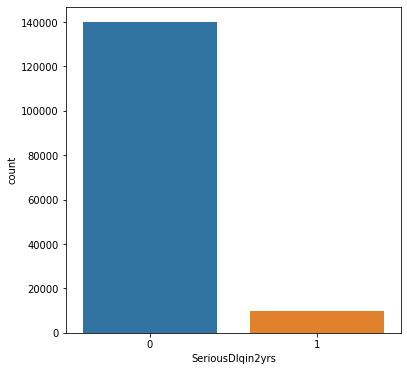

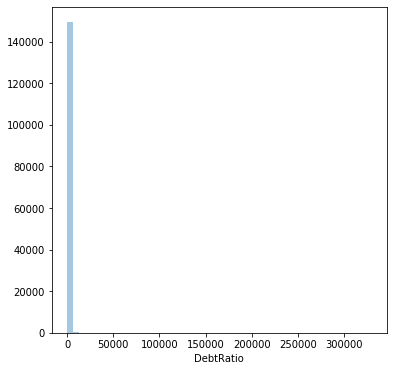

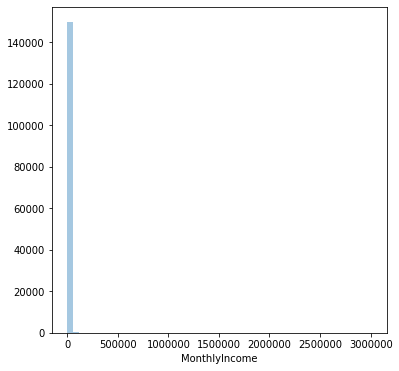

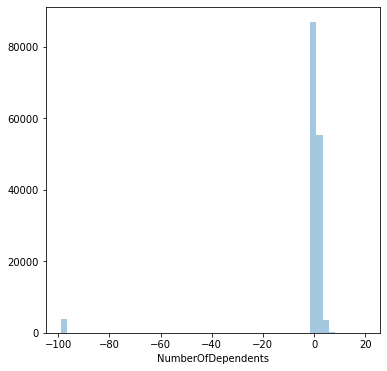

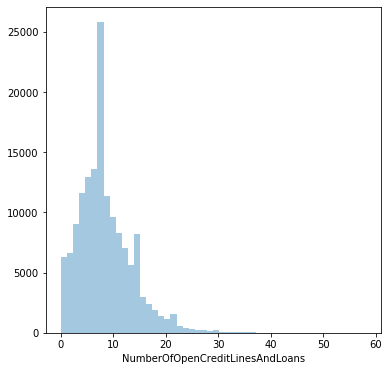

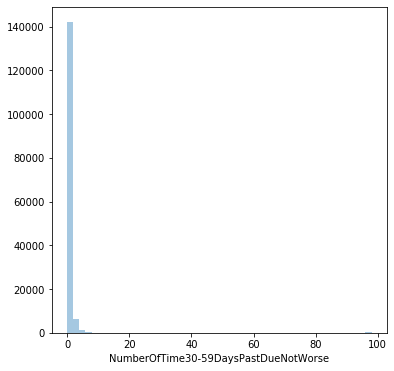

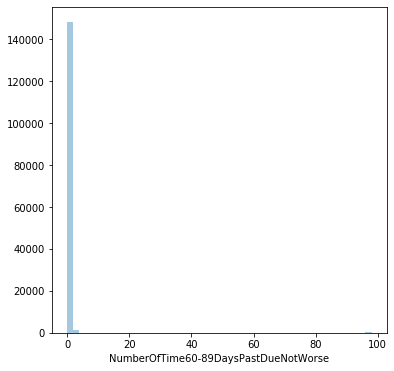

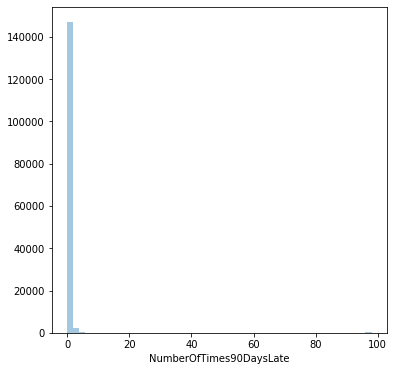

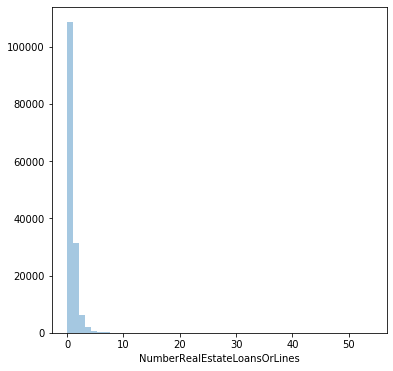

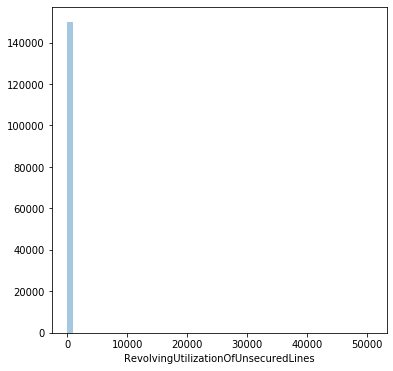

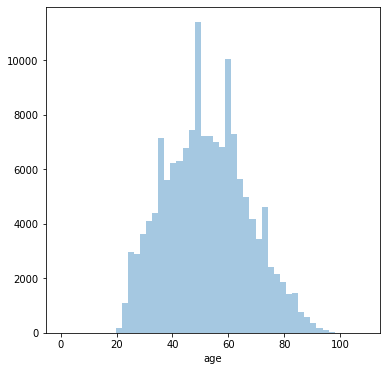

In [10]:
# Plot distributions of variables

# Plot target dist
fig, ax = plt.subplots(figsize=(6, 6))
plot = sns.countplot(df[col_target], ax=ax)
plt.show()
plot.get_figure().savefig('output/' + col_target + '_dist.png')

# Plot variable dist
plot_dist(col_vars)

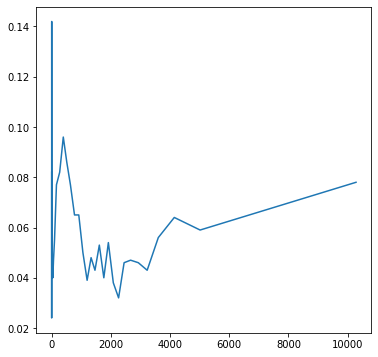

DebtRatio - by value


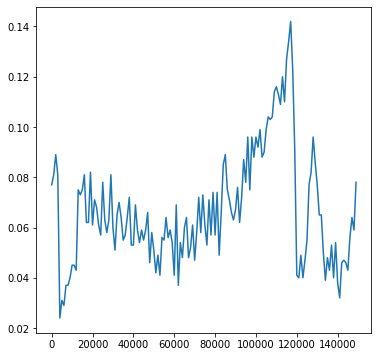

DebtRatio - by index
----------------------------------------


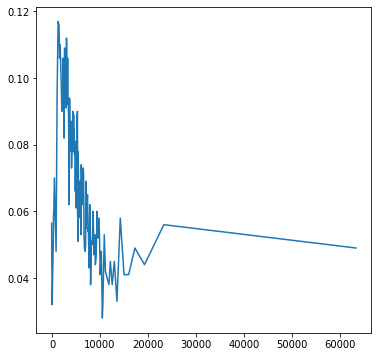

MonthlyIncome - by value


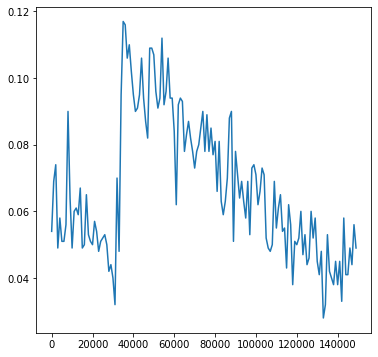

MonthlyIncome - by index
----------------------------------------


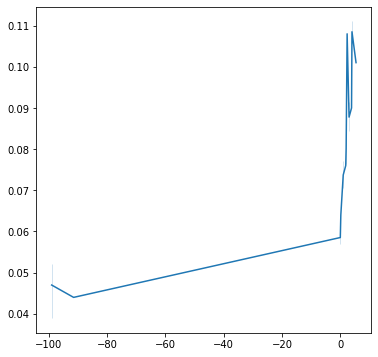

NumberOfDependents - by value


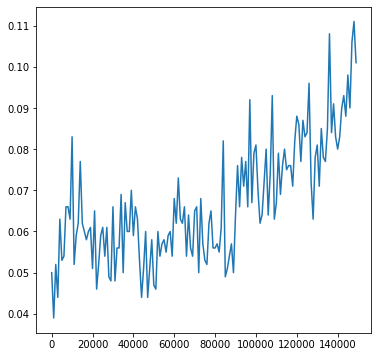

NumberOfDependents - by index
----------------------------------------


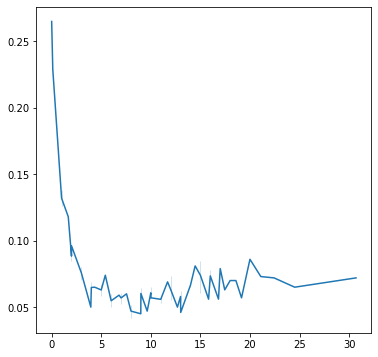

NumberOfOpenCreditLinesAndLoans - by value


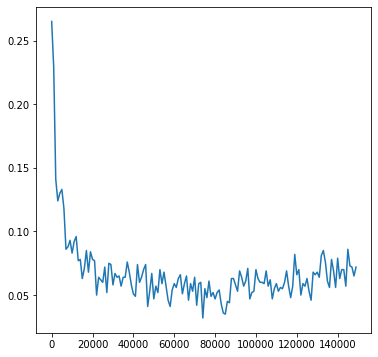

NumberOfOpenCreditLinesAndLoans - by index
----------------------------------------


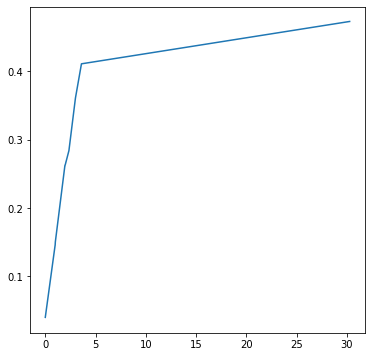

NumberOfTime30-59DaysPastDueNotWorse - by value


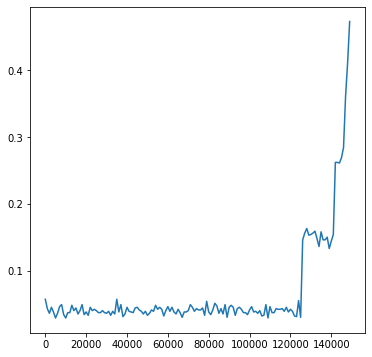

NumberOfTime30-59DaysPastDueNotWorse - by index
----------------------------------------


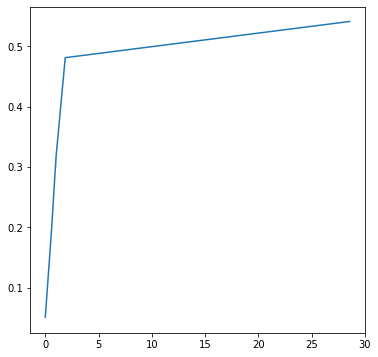

NumberOfTime60-89DaysPastDueNotWorse - by value


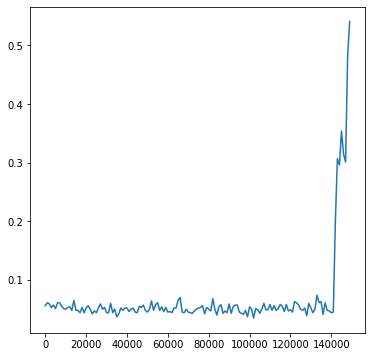

NumberOfTime60-89DaysPastDueNotWorse - by index
----------------------------------------


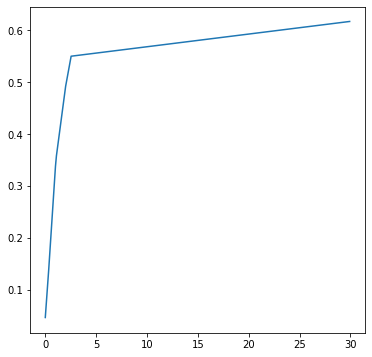

NumberOfTimes90DaysLate - by value


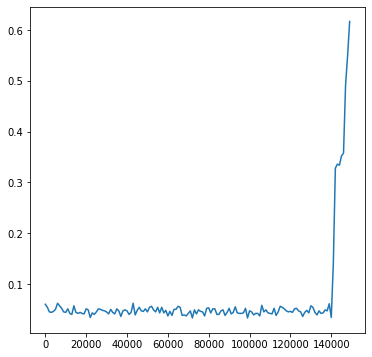

NumberOfTimes90DaysLate - by index
----------------------------------------


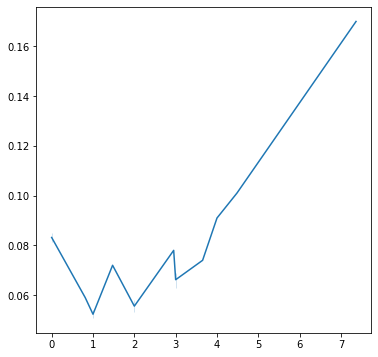

NumberRealEstateLoansOrLines - by value


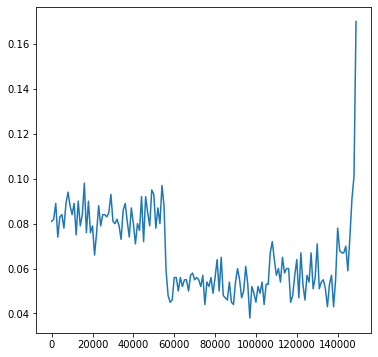

NumberRealEstateLoansOrLines - by index
----------------------------------------


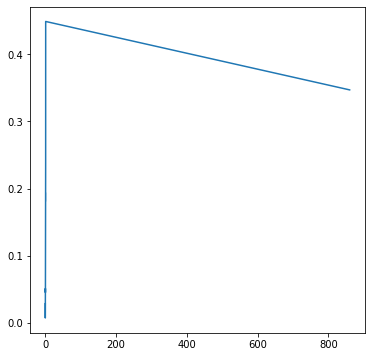

RevolvingUtilizationOfUnsecuredLines - by value


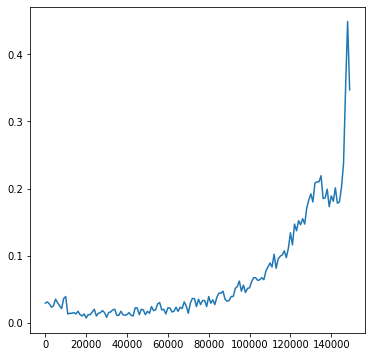

RevolvingUtilizationOfUnsecuredLines - by index
----------------------------------------


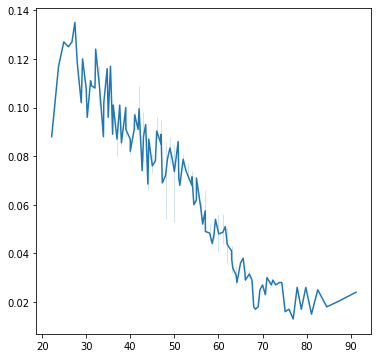

age - by value


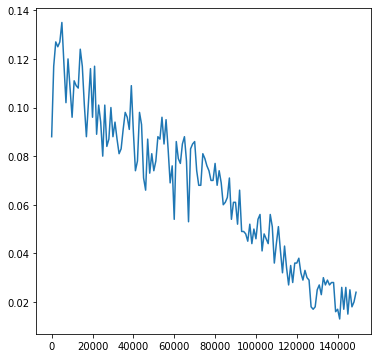

age - by index
----------------------------------------


In [11]:
# Plot default rate by variable

plot_def_rate(col_vars, col_target, 1000)

In [ ]:
# Take a look at the low extreme values

# Order by acsending
asc = True

# Show num rows
num = 20

for x in col_vars:
    print(x)
    display(df.sort_values(by = x, ascending = asc).reset_index(drop = True).head(num))
    print('')
    print('-'*40)

In [ ]:
# Take a look at the high extreme values

# Order by acsending
asc = False

# Show num rows
num = 20

for x in col_vars:
    print(x)
    display(df.sort_values(by = x, ascending = asc).reset_index(drop = True).head(num))
    print('')
    print('-'*40)

In [14]:
# Clean data

# Monthly Income
df['income_unknown'] = df['MonthlyIncome'].isna()
df['income_zero'] = df['MonthlyIncome'] < 2
df['income_clean'] = np.where(df['income_unknown'] | df['income_zero'], 0, df['MonthlyIncome'])

# Debt Ratio
df['debtratio_zero'] = df['DebtRatio'] == 0
df['debtratio_income_unknown'] = np.where(df['income_unknown'] | df['income_zero'], df['DebtRatio'], 0)
df['debtratio_clean'] = np.where(df['income_unknown'] | df['income_zero'], 0, df['DebtRatio'])

# Number Of Dependents
df['dependents_unknown'] = df['NumberOfDependents'].isna()
df['dependents_clean'] = np.where(df['dependents_unknown'], 0, df['NumberOfDependents'])

# Number Of Open Credit Lines And Loans
df['creditlines_clean'] = df['NumberOfOpenCreditLinesAndLoans']

# Number Of Time 30-59 Days Past Due Not Worse
df['times30_high'] = df['NumberOfTime30-59DaysPastDueNotWorse'] > 90
df['times30_clean'] = np.where(df['times30_high'], df['NumberOfTime30-59DaysPastDueNotWorse'][df['NumberOfTime30-59DaysPastDueNotWorse'] < 90].max(), df['NumberOfTime30-59DaysPastDueNotWorse'])

# Number Of Time 60-89 Days Past Due Not Worse
df['times60_high'] = df['NumberOfTime60-89DaysPastDueNotWorse'] > 90
df['times60_clean'] = np.where(df['times60_high'], df['NumberOfTime60-89DaysPastDueNotWorse'][df['NumberOfTime60-89DaysPastDueNotWorse'] < 90].max(), df['NumberOfTime60-89DaysPastDueNotWorse'])

# Number Of Times 90 Days Late
df['times90_high'] = df['NumberOfTimes90DaysLate'] > 90
df['times90_clean'] = np.where(df['times90_high'], df['NumberOfTimes90DaysLate'][df['NumberOfTimes90DaysLate'] < 90].max(), df['NumberOfTimes90DaysLate'])

# Number Real Estate Loans Or Lines
df['recredit_clean'] = df['NumberRealEstateLoansOrLines']

# Revolving Utilization Of Unsecured Lines
df['ur_high'] = (df['RevolvingUtilizationOfUnsecuredLines'] > 1) & (df['RevolvingUtilizationOfUnsecuredLines']%1 == 0)
df['ur_high_value'] = np.where(df['ur_high'], df['RevolvingUtilizationOfUnsecuredLines'], 0)
df['ur_zero'] = df['RevolvingUtilizationOfUnsecuredLines'] == 0
df['no_revolving'] = (df['creditlines_clean'] > 0) & (df['creditlines_clean'] - df['recredit_clean'] == 0)
df['ur_clean'] = np.where(df['ur_high'] | df['no_revolving'], 0, df['RevolvingUtilizationOfUnsecuredLines'])

# age
df['age_low'] = df['age'] < 18
df['age_clean'] = np.where(df['age_low'], 21, df['age'])


In [15]:
# Create new features

## Imputed income
# Imputed income
df['income_impute'] = df['income_clean']
for x in range(130):
    df['income_impute'] = np.where((df['income_impute'] == 0) & (df['age'] == x), df['income_clean'][(df['income_clean'] != 0) & (df['age'] == x)].median() , df['income_impute'])
df['income_impute'] = df['income_impute'].fillna(1)
# Imputed debt ratio
df['debtratio_impute'] = np.where(df['income_clean'] == 0, df['debtratio_income_unknown']/df['income_impute'], df['debtratio_clean'])
    
## Income    
# Disposable income
df['disposable_income'] = df['income_clean'] * (1 - df['debtratio_clean'])
# Disposable income (from imputed)
df['disposable_income_impute'] = df['income_impute'] * (1 - df['debtratio_impute'])

## Debt Ratio
# Debt amount
df['debt_amount'] = np.where(df['income_clean'] == 0, df['debtratio_income_unknown'], df['income_clean'] *  df['debtratio_clean'])
# Avgerage loan amount
df['avg_loan_amt'] = (df['debt_amount']/df['recredit_clean']).replace([np.inf, -np.inf, np.nan], 0)

## Number Of Dependents
# Income per person
df['income_per_person'] = df['income_clean']/(1+df['dependents_clean'])
# Income per person (from imputed)
df['income_per_person_impute'] = df['income_impute']/(1+df['dependents_clean'])
# Debt per person
df['debt_per_person'] = df['debt_amount']/(1+df['dependents_clean'])
# Loans per person
df['loans_per_person'] = df['creditlines_clean']/(1+df['dependents_clean'])
# Instalment loans per person
df['instloans_per_person'] = df['recredit_clean']/(1+df['dependents_clean'])
# Revolving loans per person
df['revloans_per_person'] = (df['creditlines_clean'] - df['recredit_clean'])/(1+df['dependents_clean'])
# Age per person
df['age_per_person'] = df['age_clean']/(1+df['dependents_clean'])

## Number Of Open Credit Lines And Loans / Number Real Estate Loans Or Lines
# Number of revolving credit lines
df['revolving_credit'] = df['creditlines_clean'] - df['recredit_clean']
# Flag no revolving credit
df['no_revolving'] = (df['creditlines_clean'] > 0) & (df['creditlines_clean'] - df['recredit_clean'] == 0)
# Flag no instalment loans
df['no_instalment'] = df['creditlines_clean'] == df['recredit_clean']
# Flag no credit
df['no_credit'] = df['creditlines_clean'] == 0

## Number Of Time 30-59 Days Past Due Not Worse / Number Of Time 60-89 Days Past Due Not Worse / Number Of Times 90 Days Late
# Flag never late
df['never_late'] = df['times30_clean'] + df['times60_clean'] + df['times90_clean'] == 0
# Number times 30+
df['times_late_30'] = df['times30_clean'] + df['times60_clean'] + df['times90_clean']
# Number times 60+
df['times_late_60'] = df['times60_clean'] + df['times90_clean']
# 60+ percentage
df['times_late_60_perc'] = (df['times_late_60']/df['times_late_30']).replace([np.inf, -np.inf, np.nan], 0)
# 90+ percentage
df['times_late_90_perc'] = (df['times90_clean']/df['times_late_30']).replace([np.inf, -np.inf, np.nan], 0)

## Revolving Utilization Of Unsecured Lines
# Number utilised revolving loans
df['ut_rev_loans'] = df['ur_clean'] * df['revolving_credit']
# Flag 0 utilised when having credit
df['zero_ut_with_loan'] = df['ur_zero'] & (df['revolving_credit'] > 0)
# Untilised revolving loans per person
df['ut_revloans_per_person'] = df['ut_rev_loans']/(1+df['dependents_clean'])

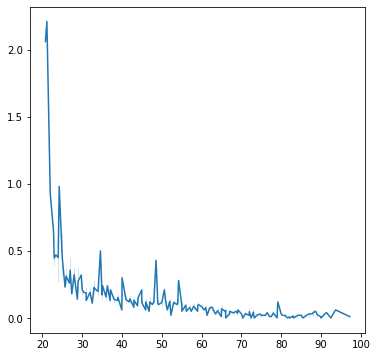

age - by value


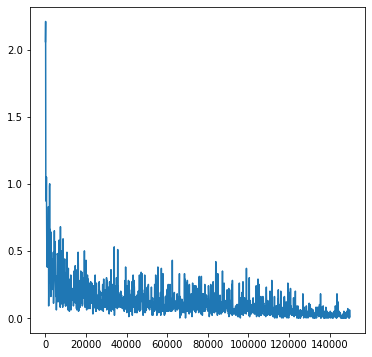

age - by index
----------------------------------------


In [16]:
# Plot 90+ clean vs age

plot_def_rate(['age'], 'times90_clean', 100)

In [17]:
# List variables for univariate analysis

train_vars = list(df.columns[1:])
for x in col_vars:    
    train_vars.remove(x)

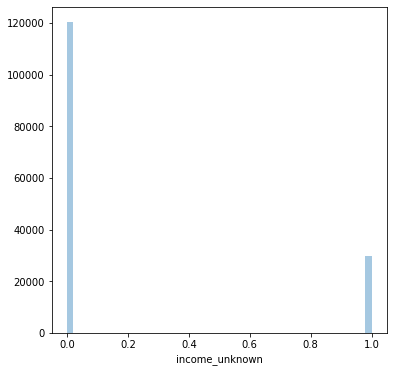

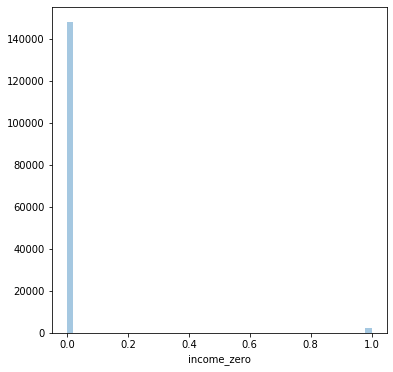

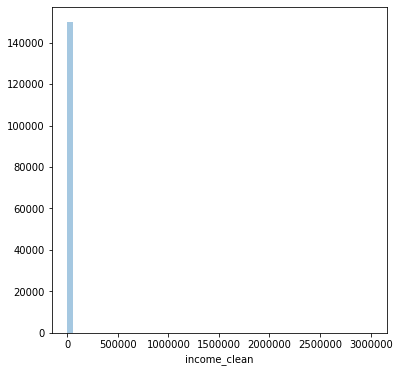

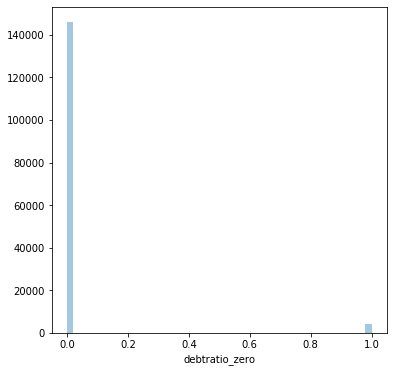

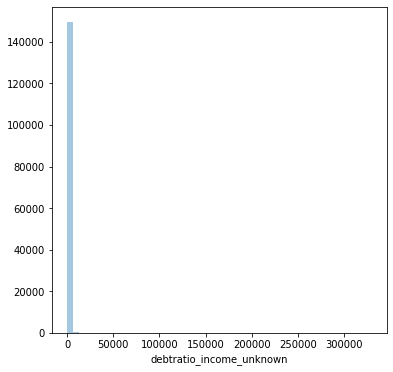

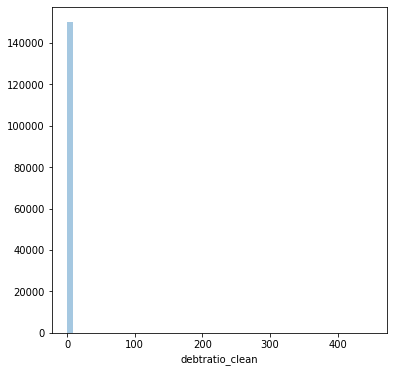

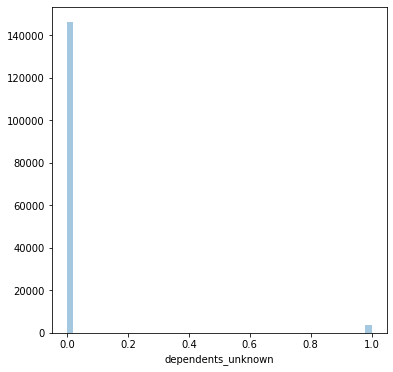

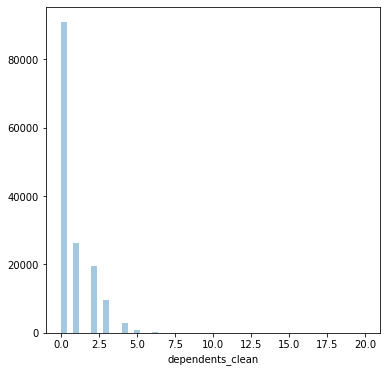

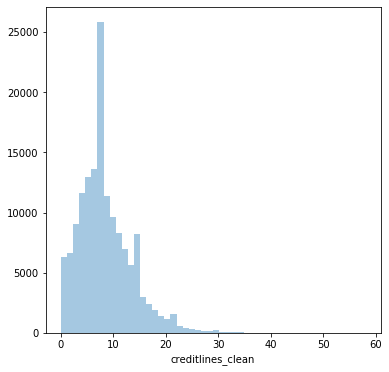

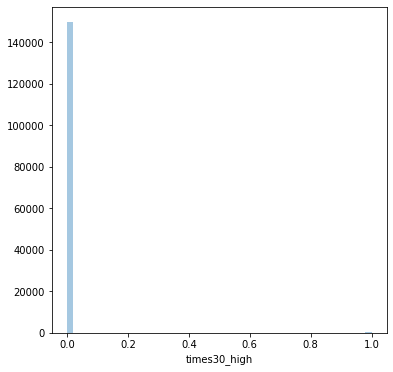

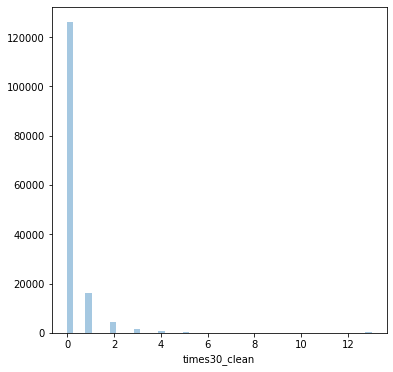

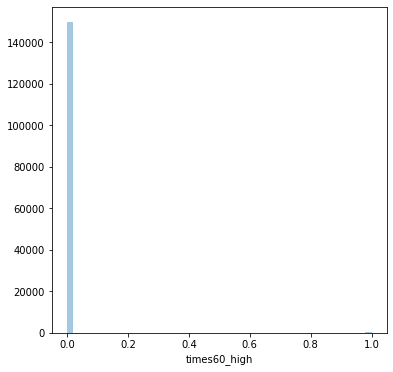

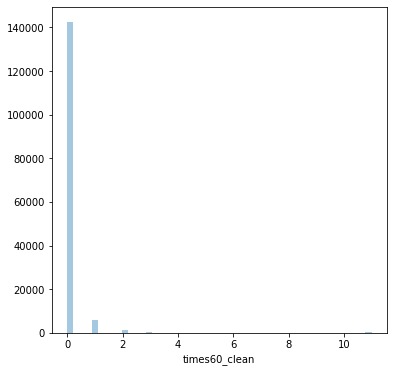

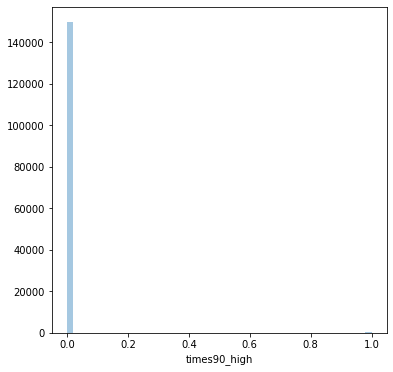

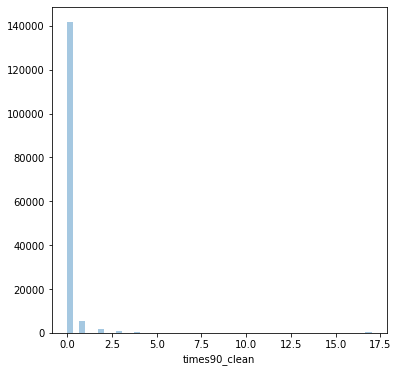

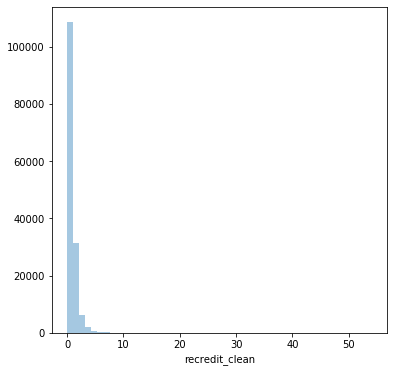

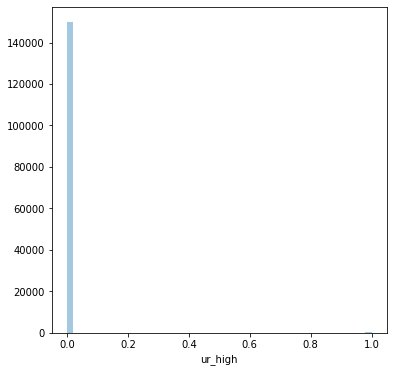

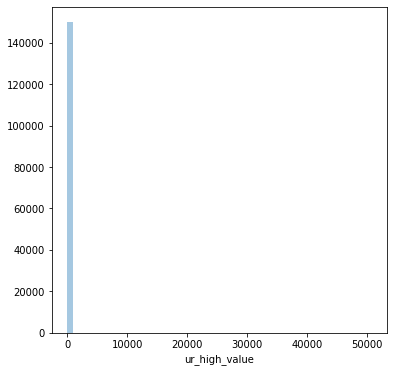

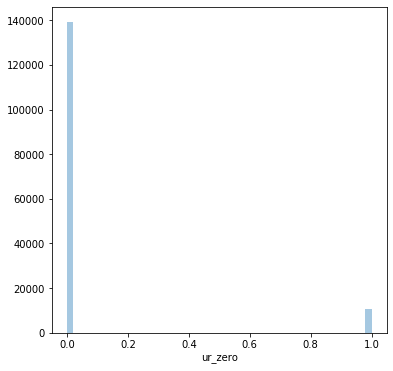

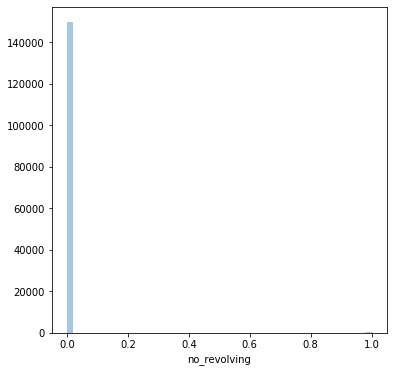

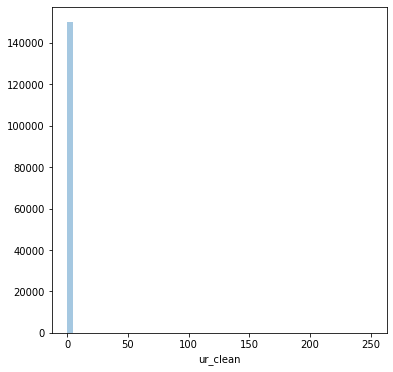

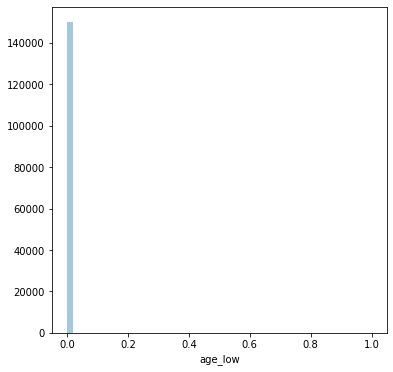

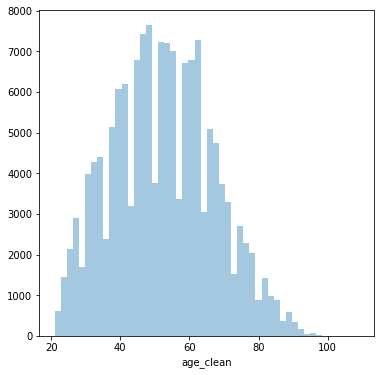

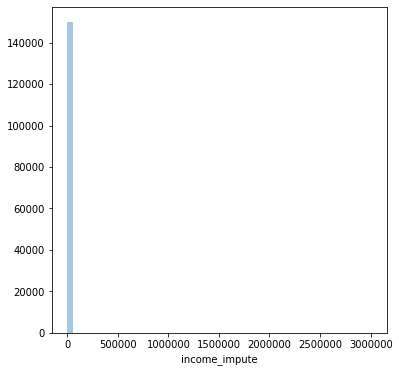

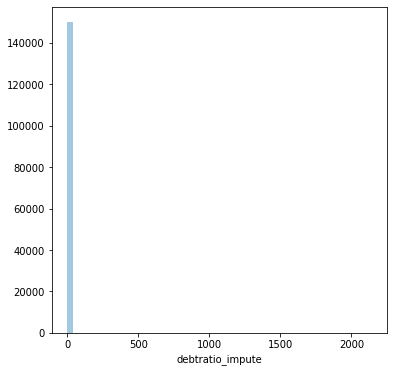

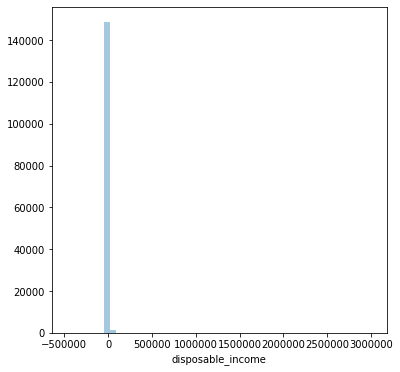

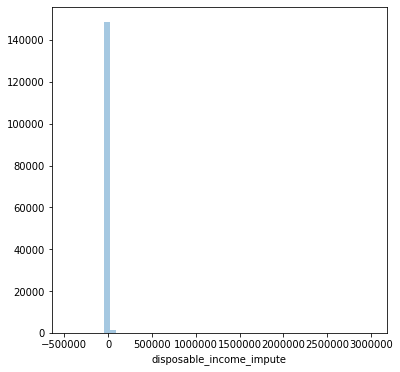

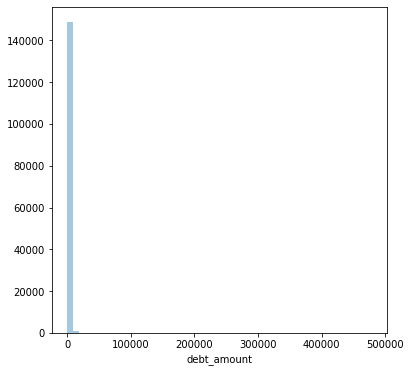

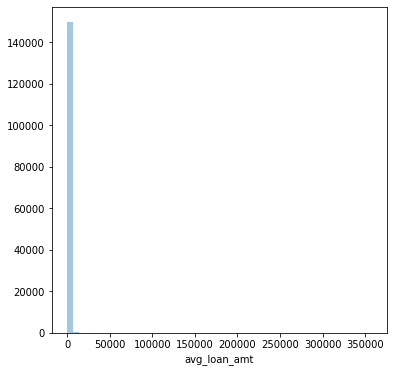

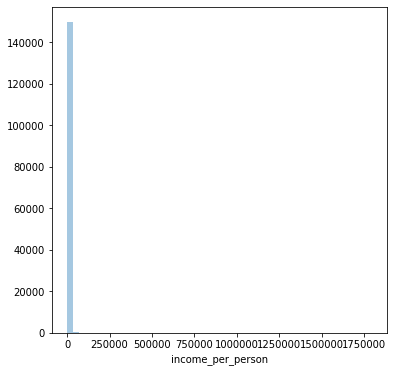

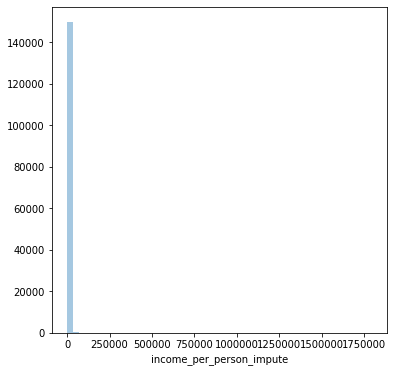

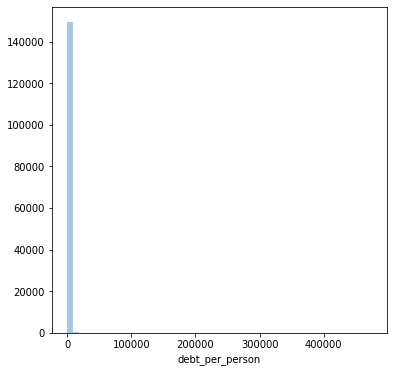

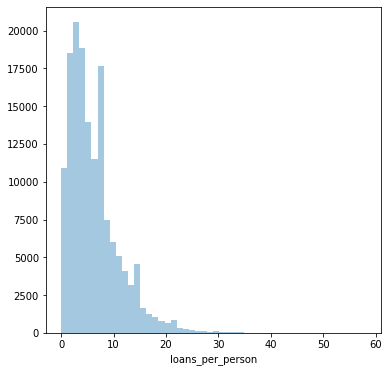

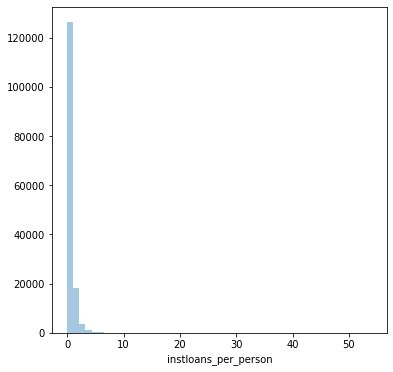

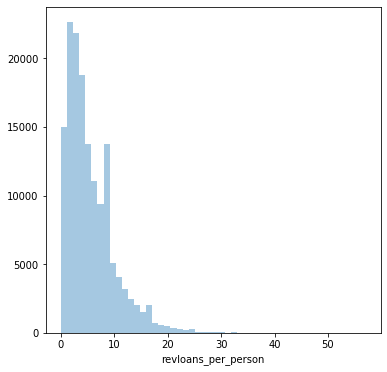

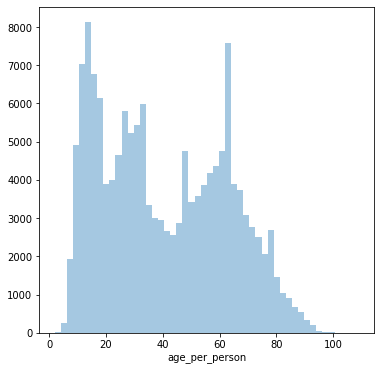

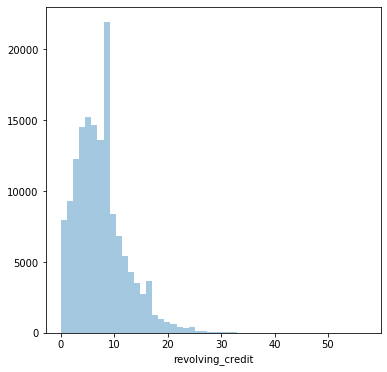

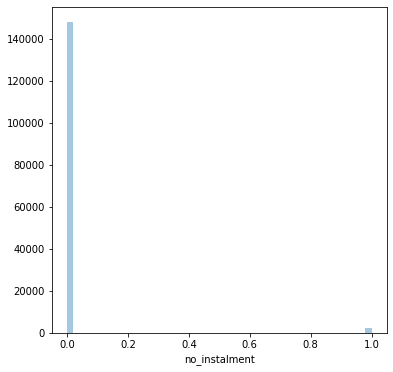

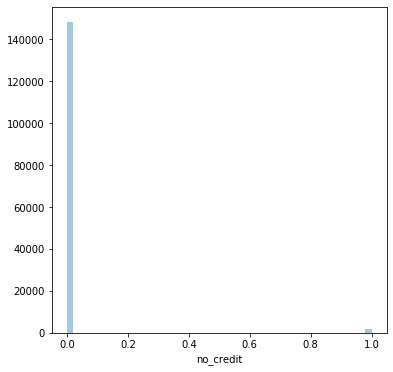

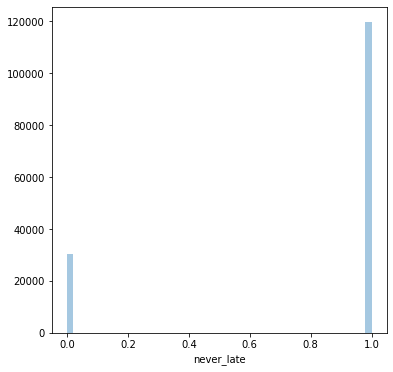

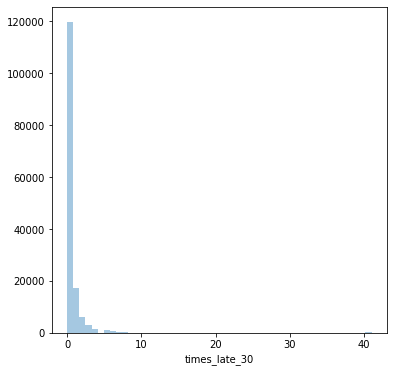

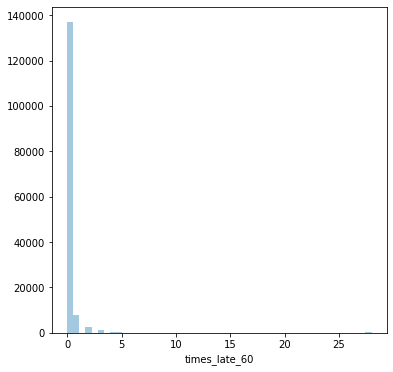

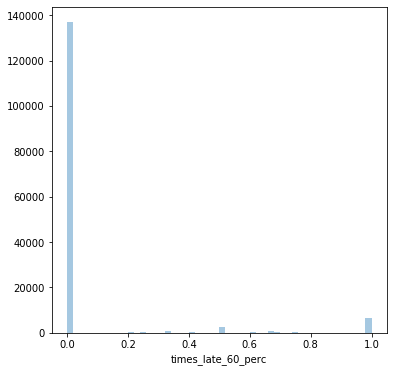

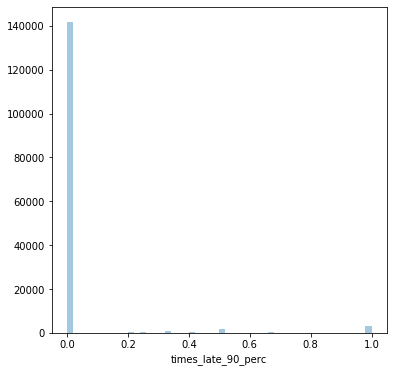

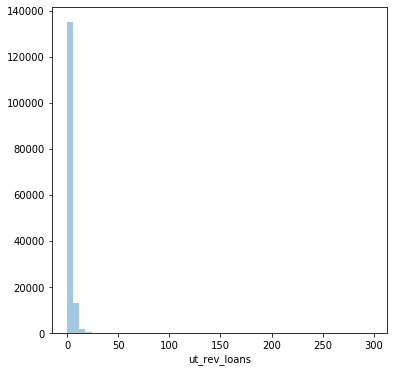

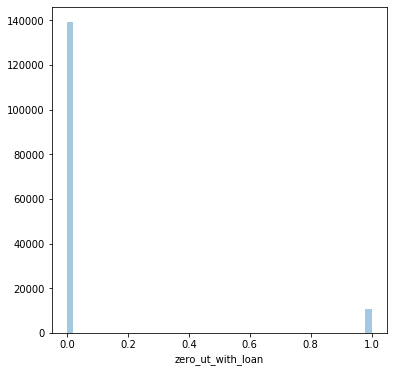

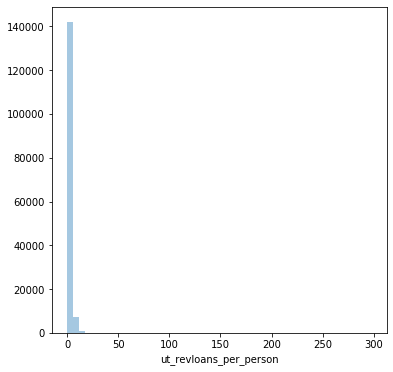

In [18]:
# Plot cleaned variable distributions

plot_dist(train_vars)

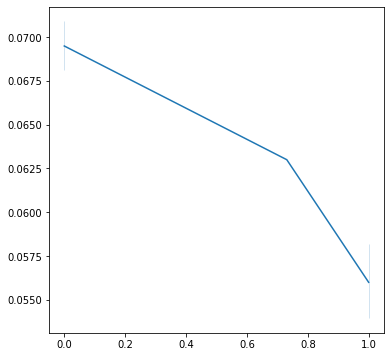

income_unknown - by value


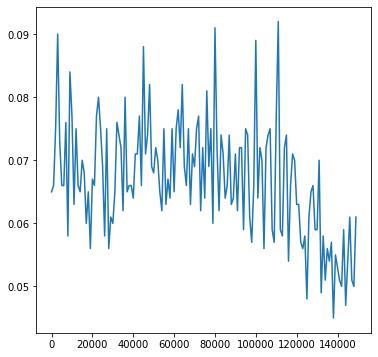

income_unknown - by index
----------------------------------------


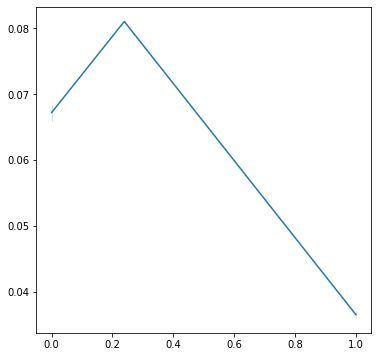

income_zero - by value


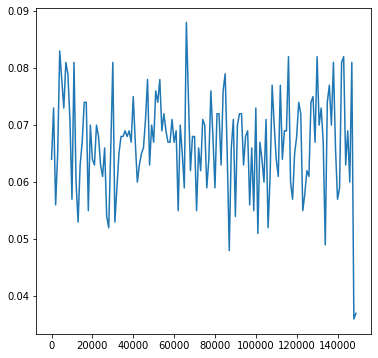

income_zero - by index
----------------------------------------


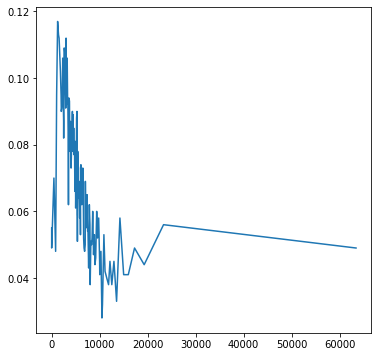

income_clean - by value


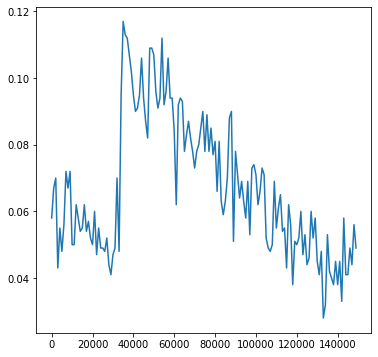

income_clean - by index
----------------------------------------


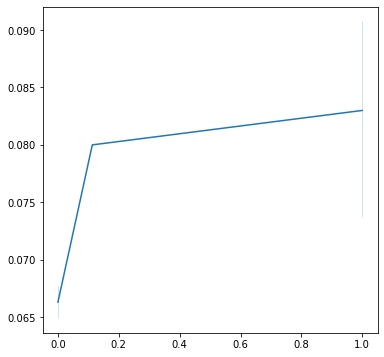

debtratio_zero - by value


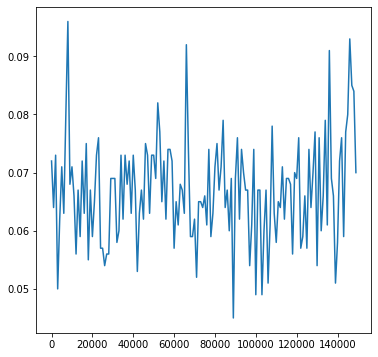

debtratio_zero - by index
----------------------------------------


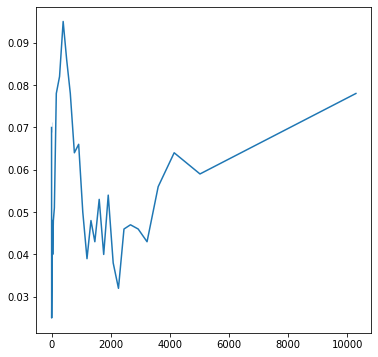

debtratio_income_unknown - by value


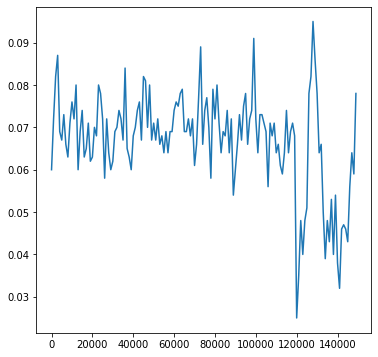

debtratio_income_unknown - by index
----------------------------------------


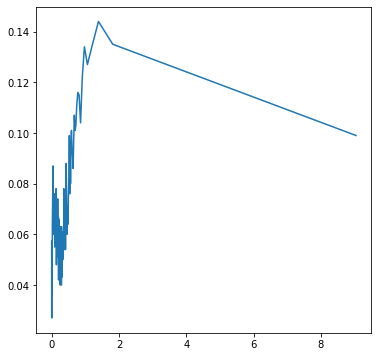

debtratio_clean - by value


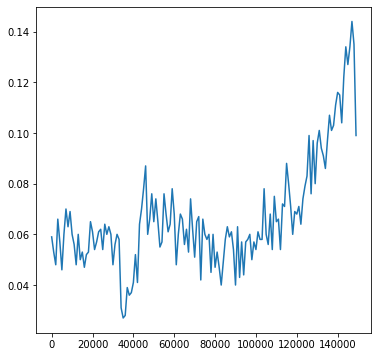

debtratio_clean - by index
----------------------------------------


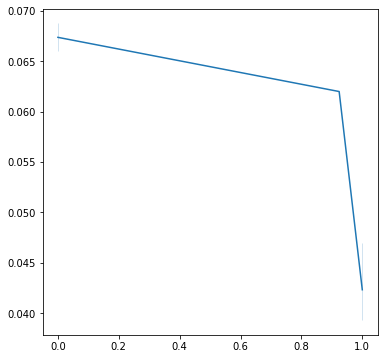

dependents_unknown - by value


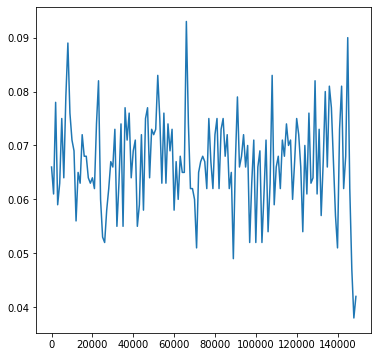

dependents_unknown - by index
----------------------------------------


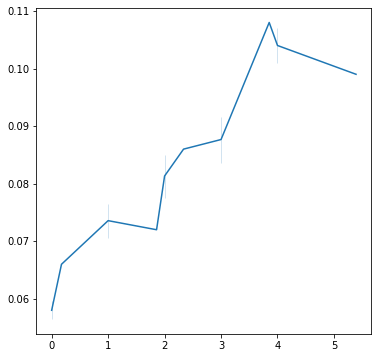

dependents_clean - by value


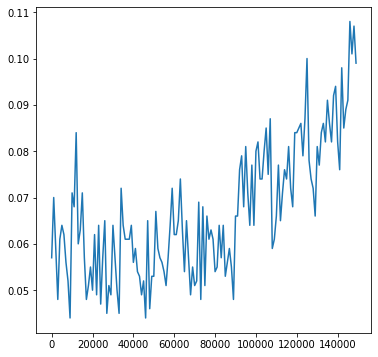

dependents_clean - by index
----------------------------------------


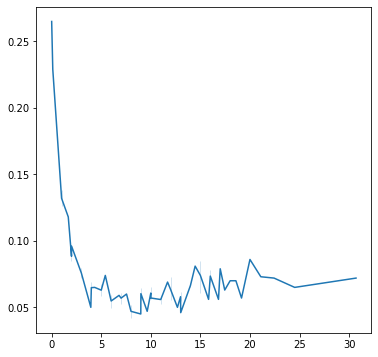

creditlines_clean - by value


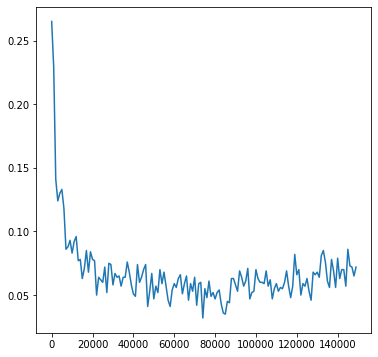

creditlines_clean - by index
----------------------------------------


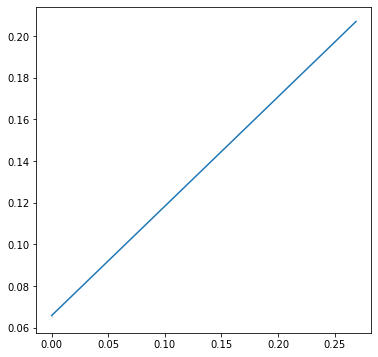

times30_high - by value


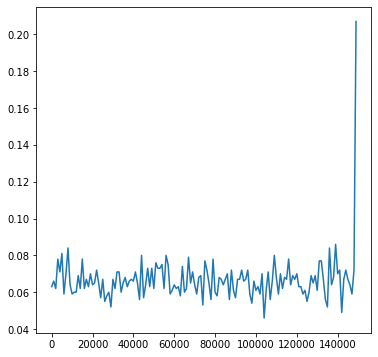

times30_high - by index
----------------------------------------


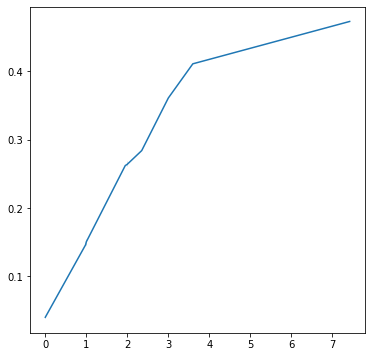

times30_clean - by value


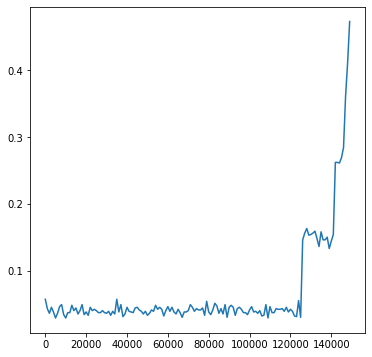

times30_clean - by index
----------------------------------------


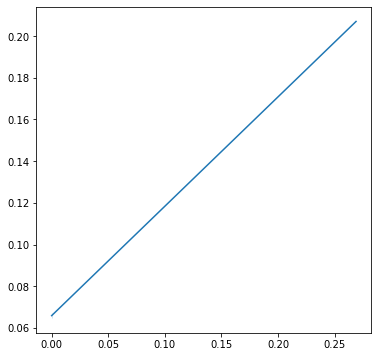

times60_high - by value


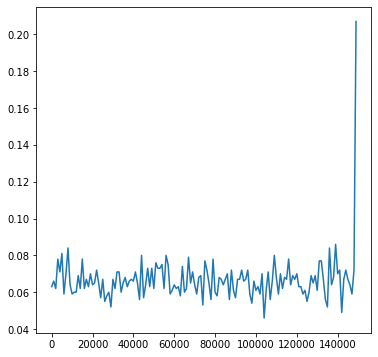

times60_high - by index
----------------------------------------


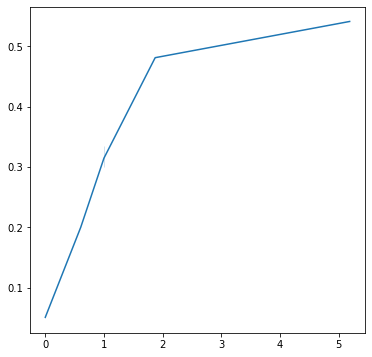

times60_clean - by value


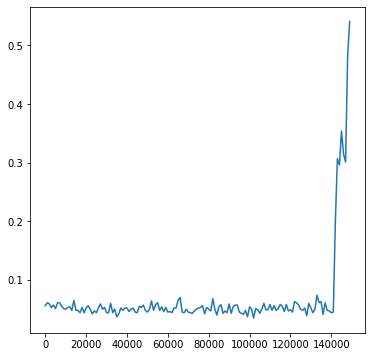

times60_clean - by index
----------------------------------------


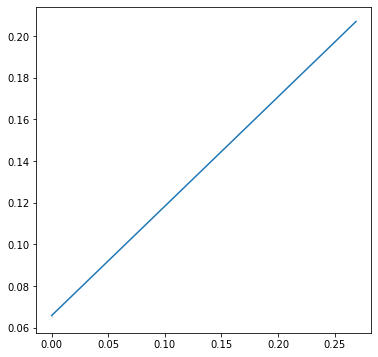

times90_high - by value


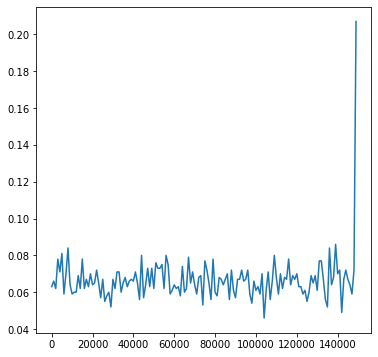

times90_high - by index
----------------------------------------


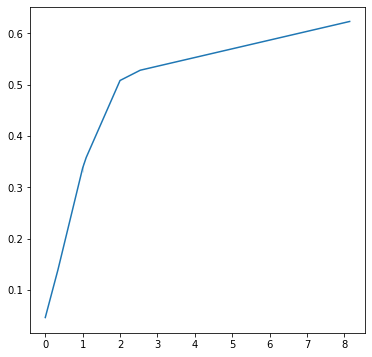

times90_clean - by value


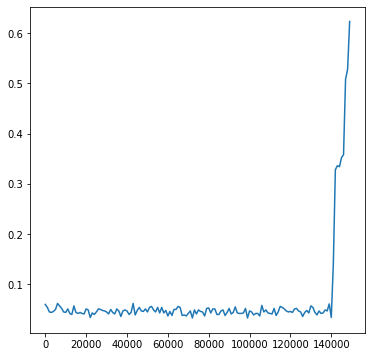

times90_clean - by index
----------------------------------------


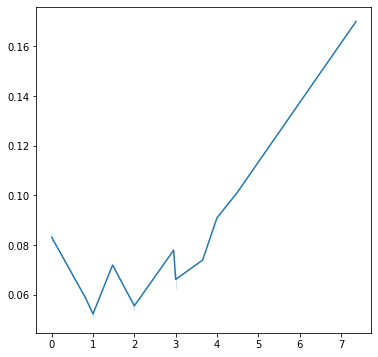

recredit_clean - by value


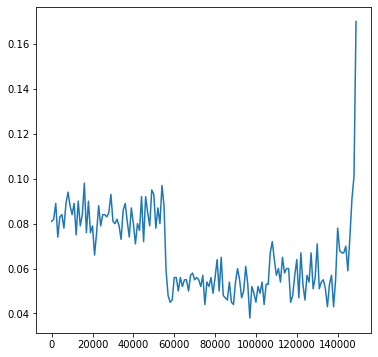

recredit_clean - by index
----------------------------------------


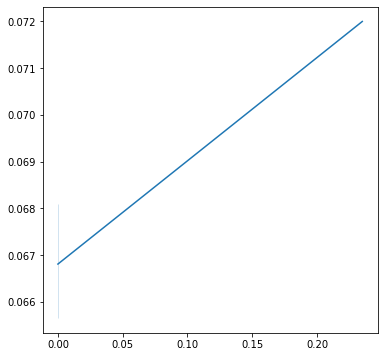

ur_high - by value


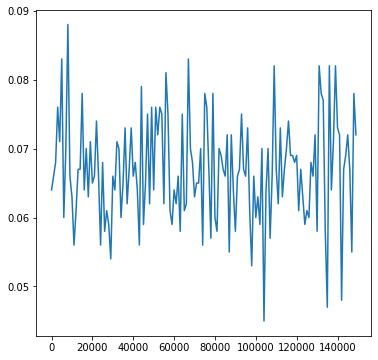

ur_high - by index
----------------------------------------


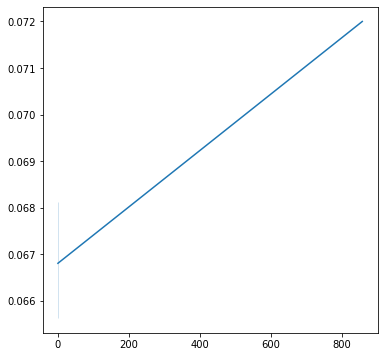

ur_high_value - by value


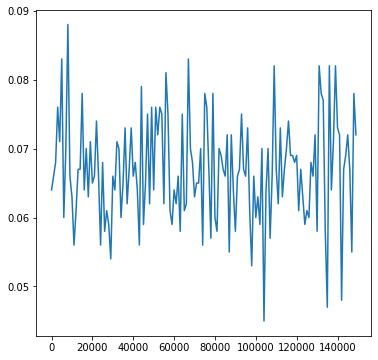

ur_high_value - by index
----------------------------------------


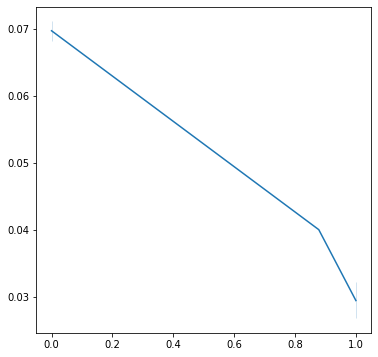

ur_zero - by value


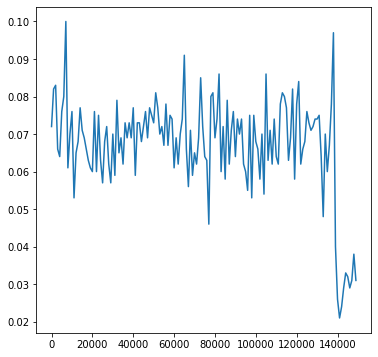

ur_zero - by index
----------------------------------------


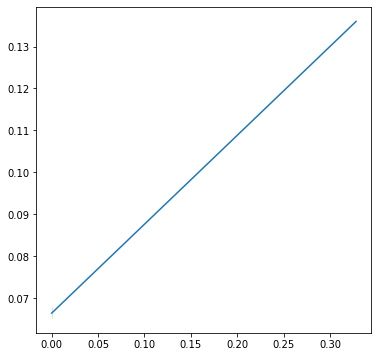

no_revolving - by value


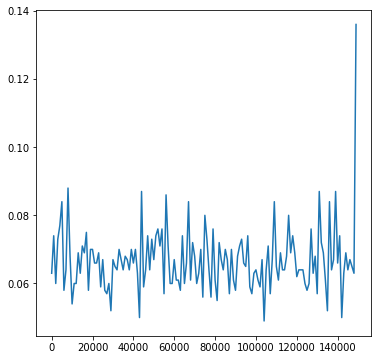

no_revolving - by index
----------------------------------------


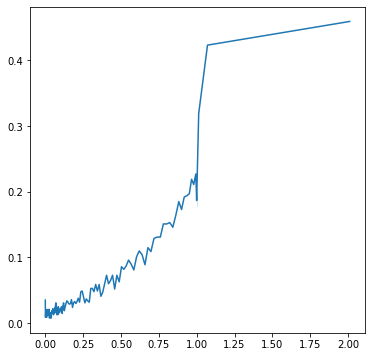

ur_clean - by value


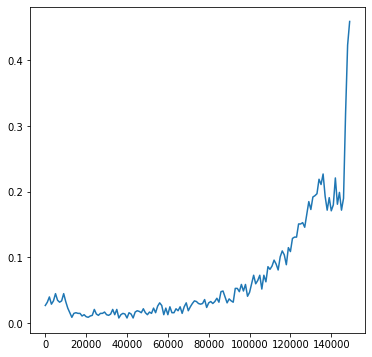

ur_clean - by index
----------------------------------------


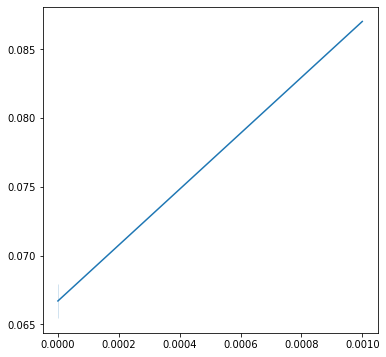

age_low - by value


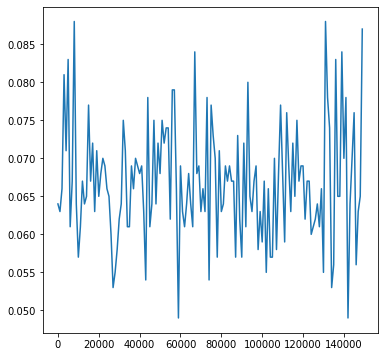

age_low - by index
----------------------------------------


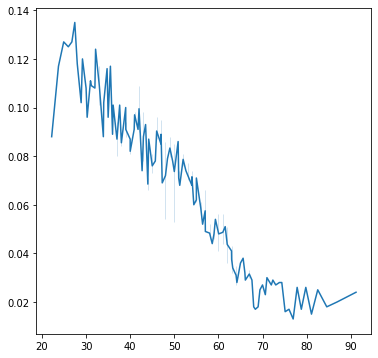

age_clean - by value


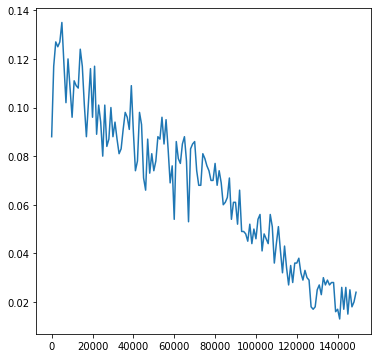

age_clean - by index
----------------------------------------


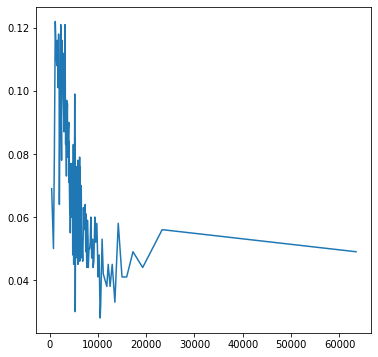

income_impute - by value


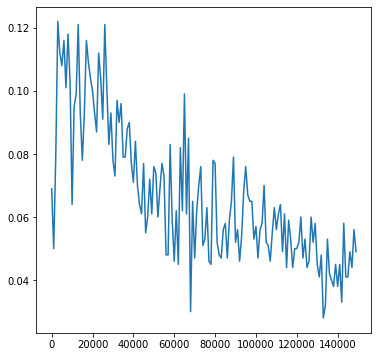

income_impute - by index
----------------------------------------


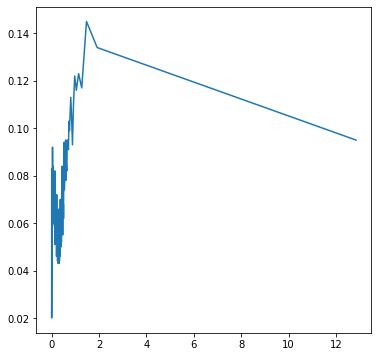

debtratio_impute - by value


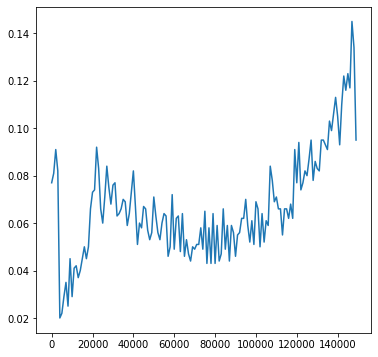

debtratio_impute - by index
----------------------------------------


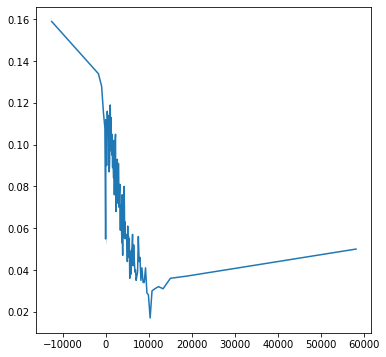

disposable_income - by value


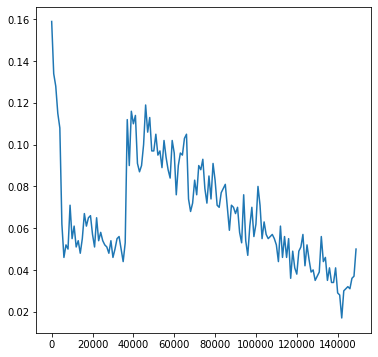

disposable_income - by index
----------------------------------------


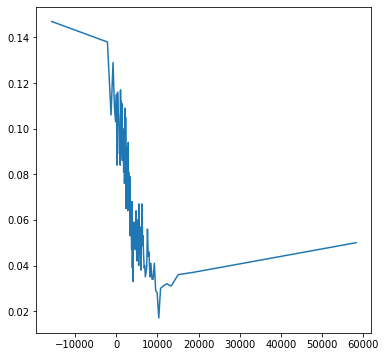

disposable_income_impute - by value


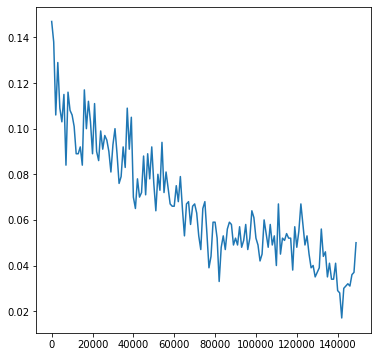

disposable_income_impute - by index
----------------------------------------


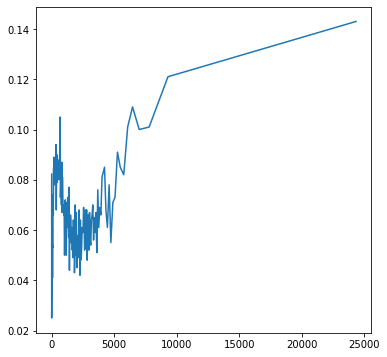

debt_amount - by value


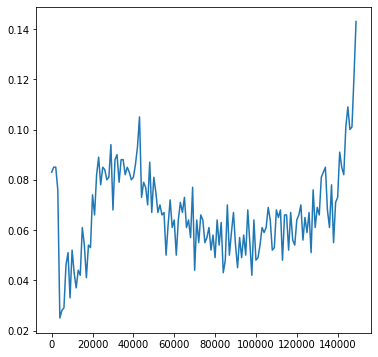

debt_amount - by index
----------------------------------------


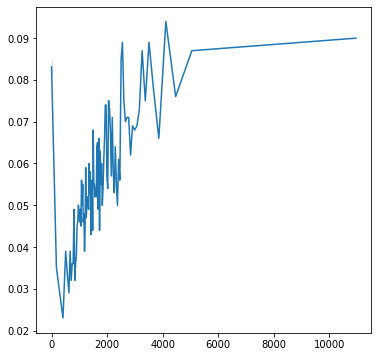

avg_loan_amt - by value


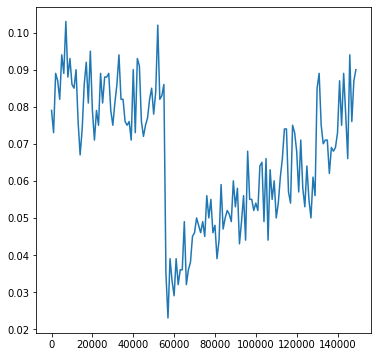

avg_loan_amt - by index
----------------------------------------


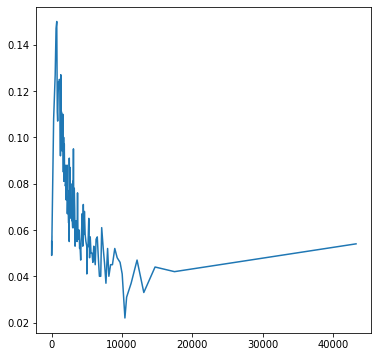

income_per_person - by value


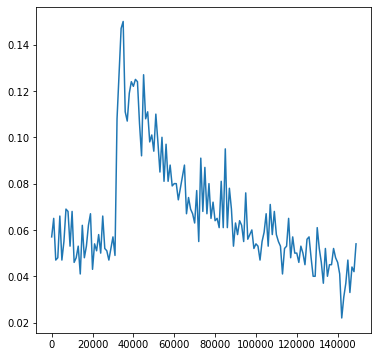

income_per_person - by index
----------------------------------------


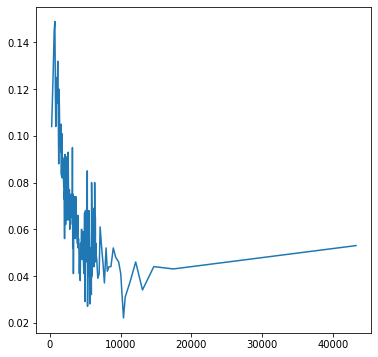

income_per_person_impute - by value


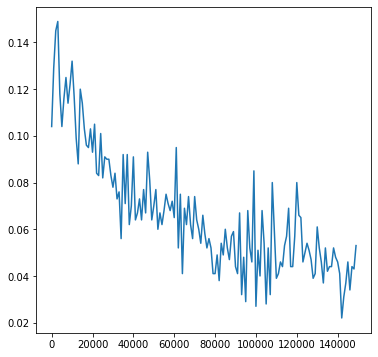

income_per_person_impute - by index
----------------------------------------


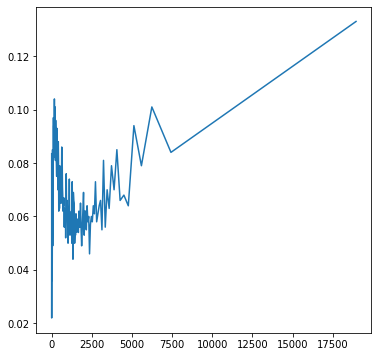

debt_per_person - by value


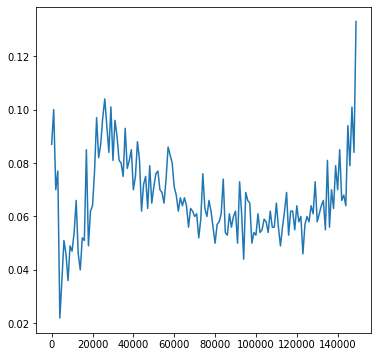

debt_per_person - by index
----------------------------------------


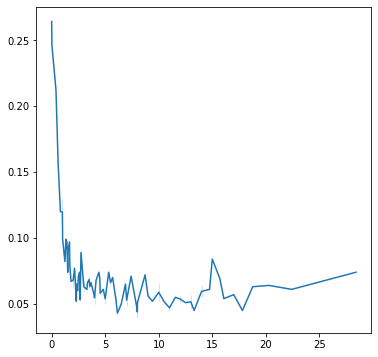

loans_per_person - by value


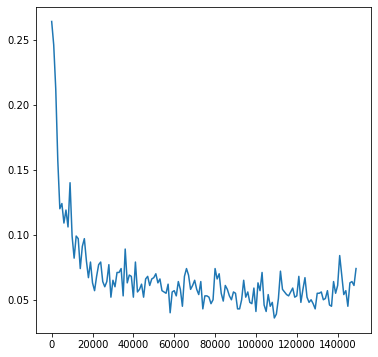

loans_per_person - by index
----------------------------------------


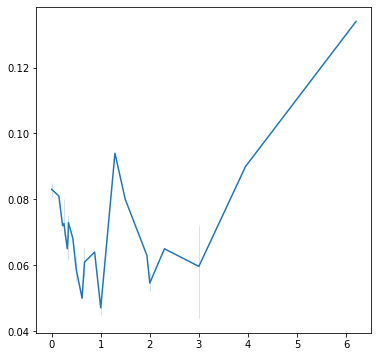

instloans_per_person - by value


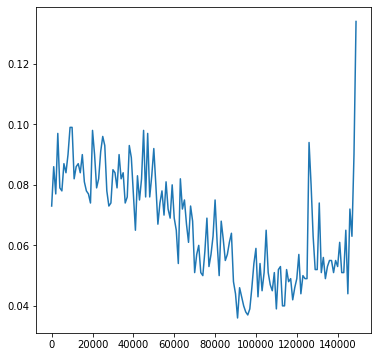

instloans_per_person - by index
----------------------------------------


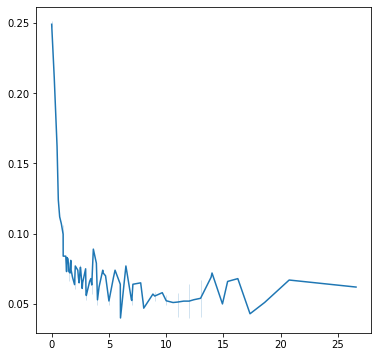

revloans_per_person - by value


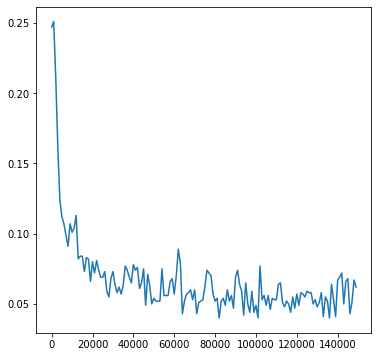

revloans_per_person - by index
----------------------------------------


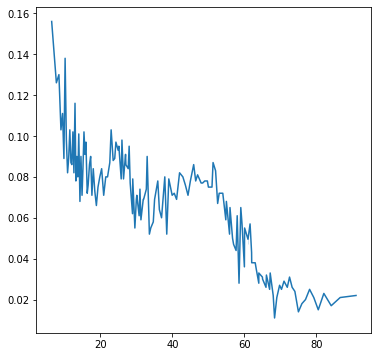

age_per_person - by value


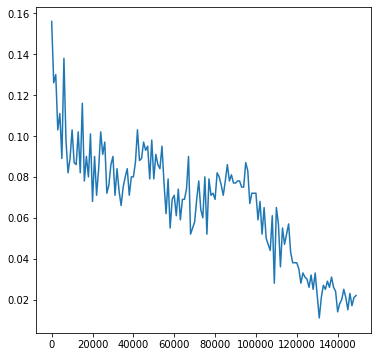

age_per_person - by index
----------------------------------------


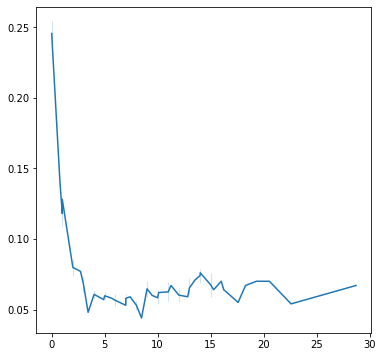

revolving_credit - by value


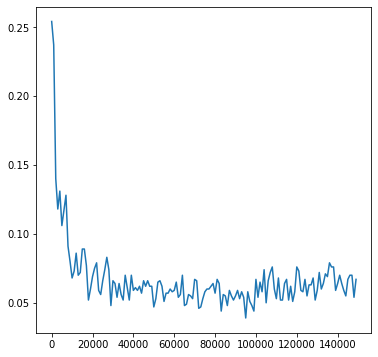

revolving_credit - by index
----------------------------------------


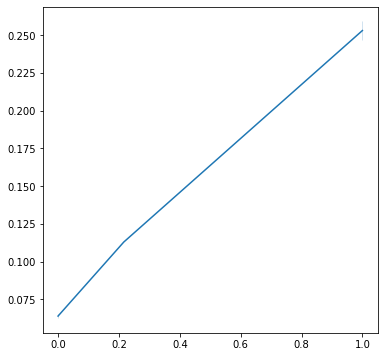

no_instalment - by value


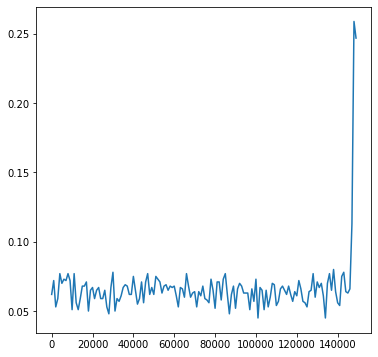

no_instalment - by index
----------------------------------------


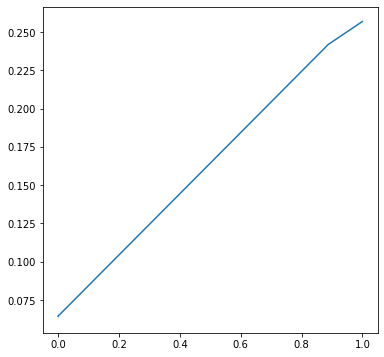

no_credit - by value


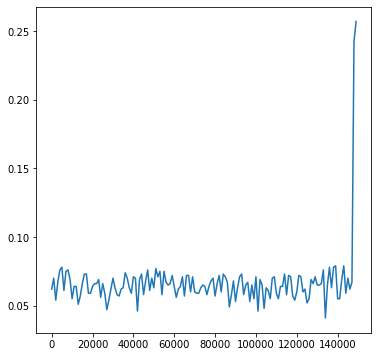

no_credit - by index
----------------------------------------


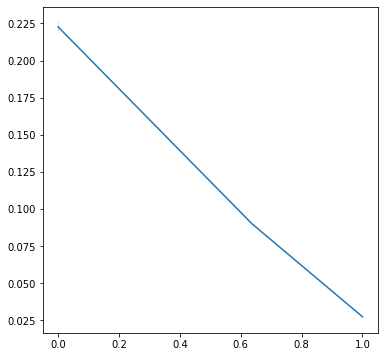

never_late - by value


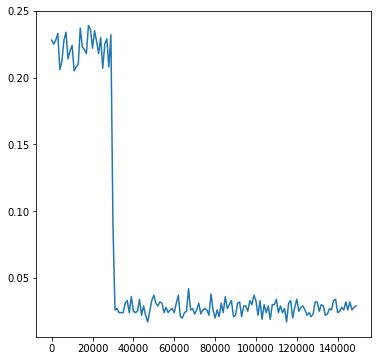

never_late - by index
----------------------------------------


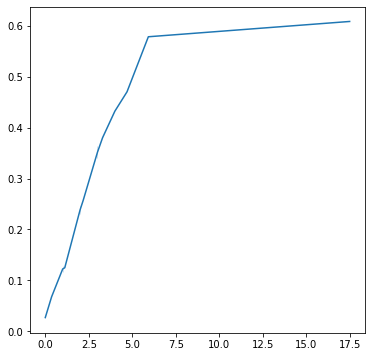

times_late_30 - by value


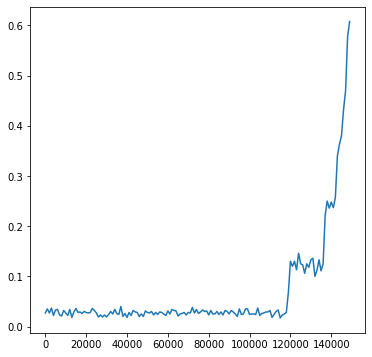

times_late_30 - by index
----------------------------------------


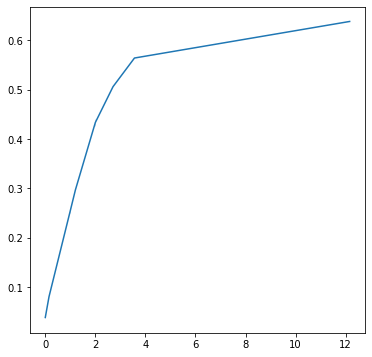

times_late_60 - by value


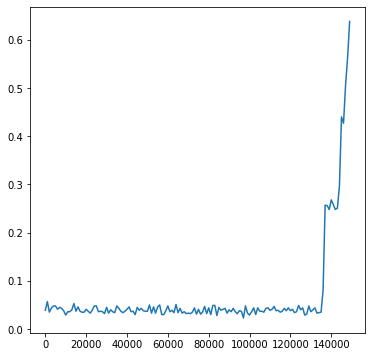

times_late_60 - by index
----------------------------------------


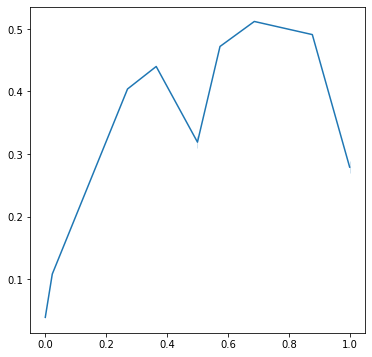

times_late_60_perc - by value


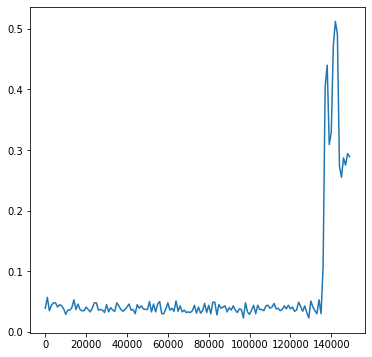

times_late_60_perc - by index
----------------------------------------


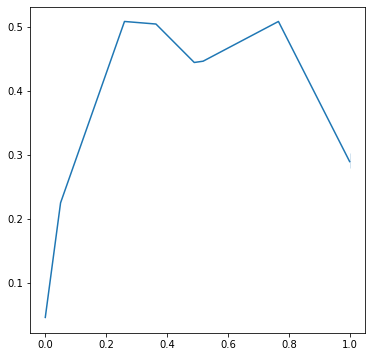

times_late_90_perc - by value


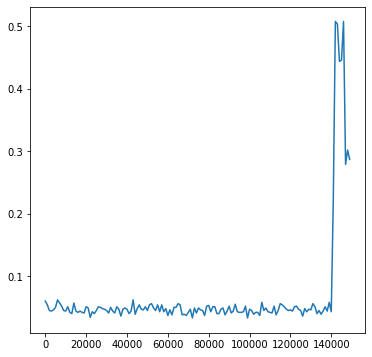

times_late_90_perc - by index
----------------------------------------


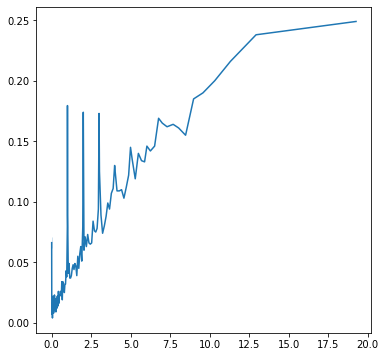

ut_rev_loans - by value


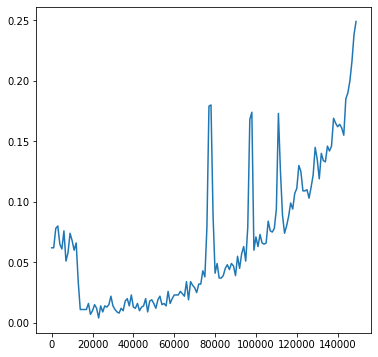

ut_rev_loans - by index
----------------------------------------


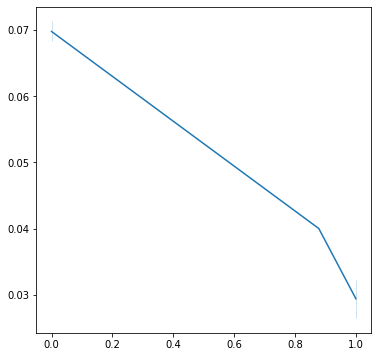

zero_ut_with_loan - by value


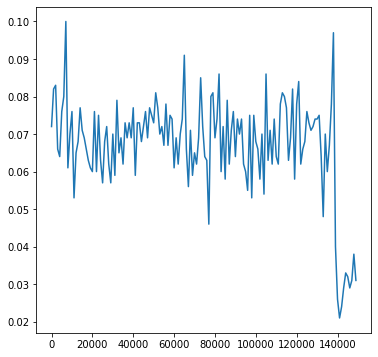

zero_ut_with_loan - by index
----------------------------------------


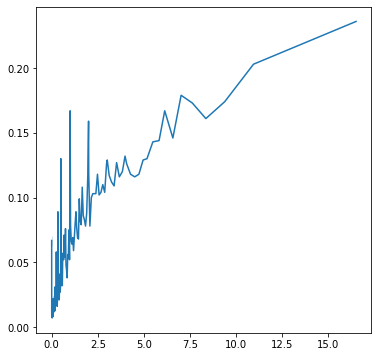

ut_revloans_per_person - by value


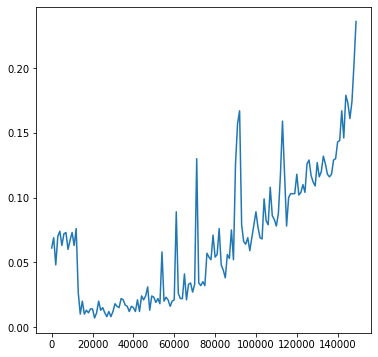

ut_revloans_per_person - by index
----------------------------------------


In [19]:
# Plot cleaned variables vs default rate

plot_def_rate(train_vars, col_target, 1000)

In [20]:
# Calculate univariate gini

# Calculate univariate auc for cleaned variables
uni_auc_out = uni_auc(train_vars, col_target, 4, 6, 200)

# Calculate gini
uni_auc_out['gini'] = 2*(uni_auc_out['auc']-0.5)

# Show result
uni_auc_clean = uni_auc_out.sort_values(by = 'auc', ascending = False).reset_index(drop = True)
uni_auc_clean

variable       auc      gini
0              times_late_30  0.775812  0.551624
1                   ur_clean  0.766461  0.532922
2                 never_late  0.752918  0.505837
3               ut_rev_loans  0.724770  0.449539
4              times_late_60  0.708346  0.416692
5         times_late_60_perc  0.707414  0.414829
6     ut_revloans_per_person  0.700841  0.401682
7              times30_clean  0.689533  0.379066
8         times_late_90_perc  0.657329  0.314657
9              times90_clean  0.657110  0.314220
10                 age_clean  0.632370  0.264740
11             times60_clean  0.621738  0.243476
12            age_per_person  0.610416  0.220831
13         disposable_income  0.602813  0.205626
14  disposable_income_impute  0.602077  0.204153
15  income_per_person_impute  0.594706  0.189413
16         income_per_person  0.590278  0.180555
17              income_clean  0.583428  0.166856
18             income_impute  0.581345  0.162690
19          debtratio_impute  0.579948  0.159895
20          loans_per_person  0.575672  0.151344
21       revloans_per_person  0.573751  0.147503
22           debtratio_clean  0.571484  0.142968
23              avg_loan_amt  0.571466  0.142932
24         creditlines_clean  0.566109  0.132217
25      instloans_per_person  0.564683  0.129367
26            recredit_clean  0.563192  0.126385
27               debt_amount  0.559111  0.118221
28          revolving_credit  0.551729  0.103458
29           debt_per_person  0.550457  0.100915
30          dependents_clean  0.547590  0.095179
31  debtratio_income_unknown  0.531175  0.062349
32             no_instalment  0.521798  0.043596
33                   ur_zero  0.521756  0.043511
34         zero_ut_with_loan  0.521756  0.043511
35                 no_credit  0.519122  0.038244
36            income_unknown  0.517006  0.034013
37              times30_high  0.506895  0.013790
38              times60_high  0.506895  0.013790
39              times90_high  0.506895  0.013790
40        dependents_unknown  0.504451  0.008901
41               income_zero  0.503562  0.007124
42            debtratio_zero  0.503478  0.006957
43              no_revolving  0.502676  0.005352
44                   ur_high  0.500305  0.000610
45             ur_high_value  0.500305  0.000610
46                   age_low  0.500000  0.000000

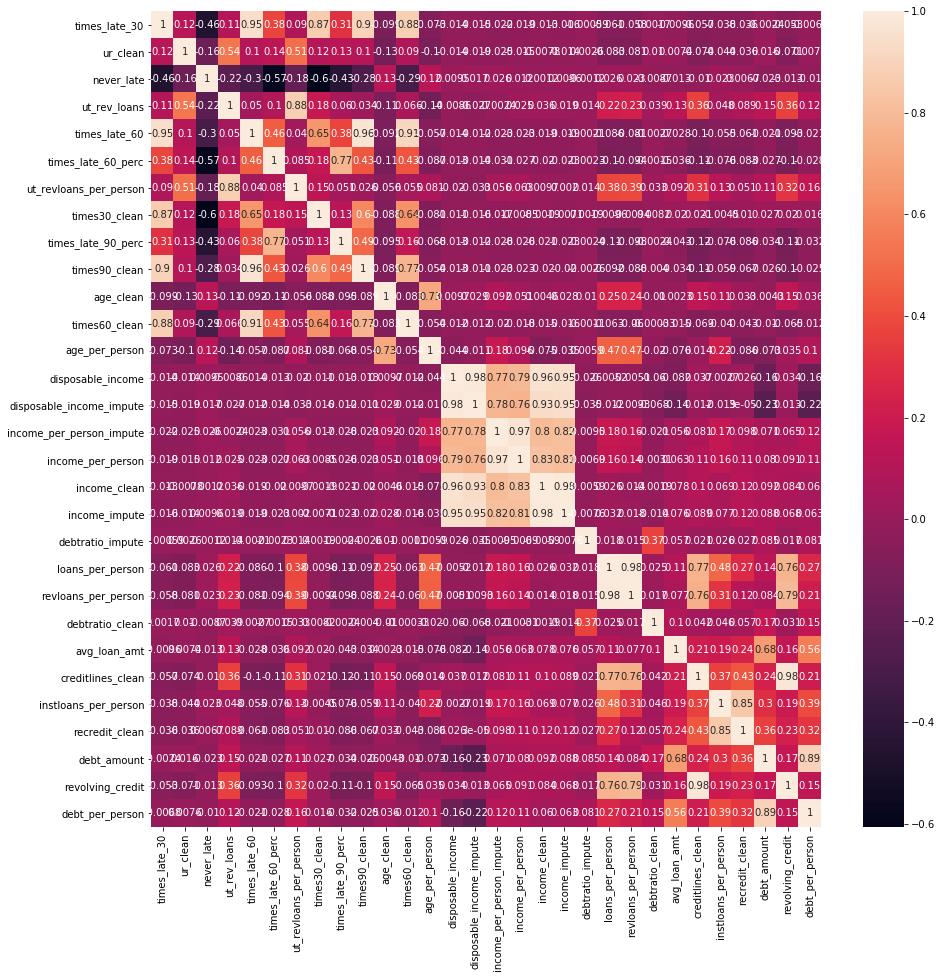

In [21]:
# Calculate correlation matrix for variables with high gini

# Set min gini
gini_min = 0.1

corr_matrix = df[uni_auc_clean['variable'][uni_auc_clean['gini'] >= gini_min]].corr()
fig, ax = plt.subplots(figsize=(15, 15))
sns.heatmap(corr_matrix, annot=True, ax=ax)
plt.show()

In [22]:
# Predictor selection

# Set min gini/max correlation
gini_min = 0.1
corr_max = 0.9

# Get gini
gini_var = list(uni_auc_clean['variable'])
gini_val = list(uni_auc_clean['gini'])

# Variable selection
final_vars = []
for i,y in zip(gini_var, gini_val):
    print('-'*40)
    print('Variable:', i)
    if y < gini_min:
        print('Gini below:', gini_min)
        continue
    if not final_vars:
        final_vars.append(i)
        print('Variable added')
        continue
    corr_list = []
    for z in final_vars:
        corr = stat.pearsonr(df[i], df[z])
        corr_list.append(corr[0])
    if np.max(np.abs(corr_list)) >= corr_max:
        print('Max correlation above', corr_max)
        continue
    final_vars.append(i)
    print('Variable added')

print('-'*40)
print('Number of variables for model input:', len(final_vars))
print('-'*40)
uni_auc_clean[uni_auc_clean['variable'].isin(final_vars)].reset_index(drop = True)

----------------------------------------
Variable: times_late_30
Variable added
----------------------------------------
Variable: ur_clean
Variable added
----------------------------------------
Variable: never_late
Variable added
----------------------------------------
Variable: ut_rev_loans
Variable added
----------------------------------------
Variable: times_late_60
Max correlation above 0.9
----------------------------------------
Variable: times_late_60_perc
Variable added
----------------------------------------
Variable: ut_revloans_per_person
Variable added
----------------------------------------
Variable: times30_clean
Variable added
----------------------------------------
Variable: times_late_90_perc
Variable added
----------------------------------------
Variable: times90_clean
Variable added
----------------------------------------
Variable: age_clean
Variable added
----------------------------------------
Variable: times60_clean
Variable added
-----------------------

variable       auc      gini
0              times_late_30  0.775812  0.551624
1                   ur_clean  0.766461  0.532922
2                 never_late  0.752918  0.505837
3               ut_rev_loans  0.724770  0.449539
4         times_late_60_perc  0.707414  0.414829
5     ut_revloans_per_person  0.700841  0.401682
6              times30_clean  0.689533  0.379066
7         times_late_90_perc  0.657329  0.314657
8              times90_clean  0.657110  0.314220
9                  age_clean  0.632370  0.264740
10             times60_clean  0.621738  0.243476
11            age_per_person  0.610416  0.220831
12         disposable_income  0.602813  0.205626
13  income_per_person_impute  0.594706  0.189413
14          debtratio_impute  0.579948  0.159895
15          loans_per_person  0.575672  0.151344
16           debtratio_clean  0.571484  0.142968
17              avg_loan_amt  0.571466  0.142932
18         creditlines_clean  0.566109  0.132217
19      instloans_per_person  0.564683  0.129367
20            recredit_clean  0.563192  0.126385
21               debt_amount  0.559111  0.118221
22           debt_per_person  0.550457  0.100915

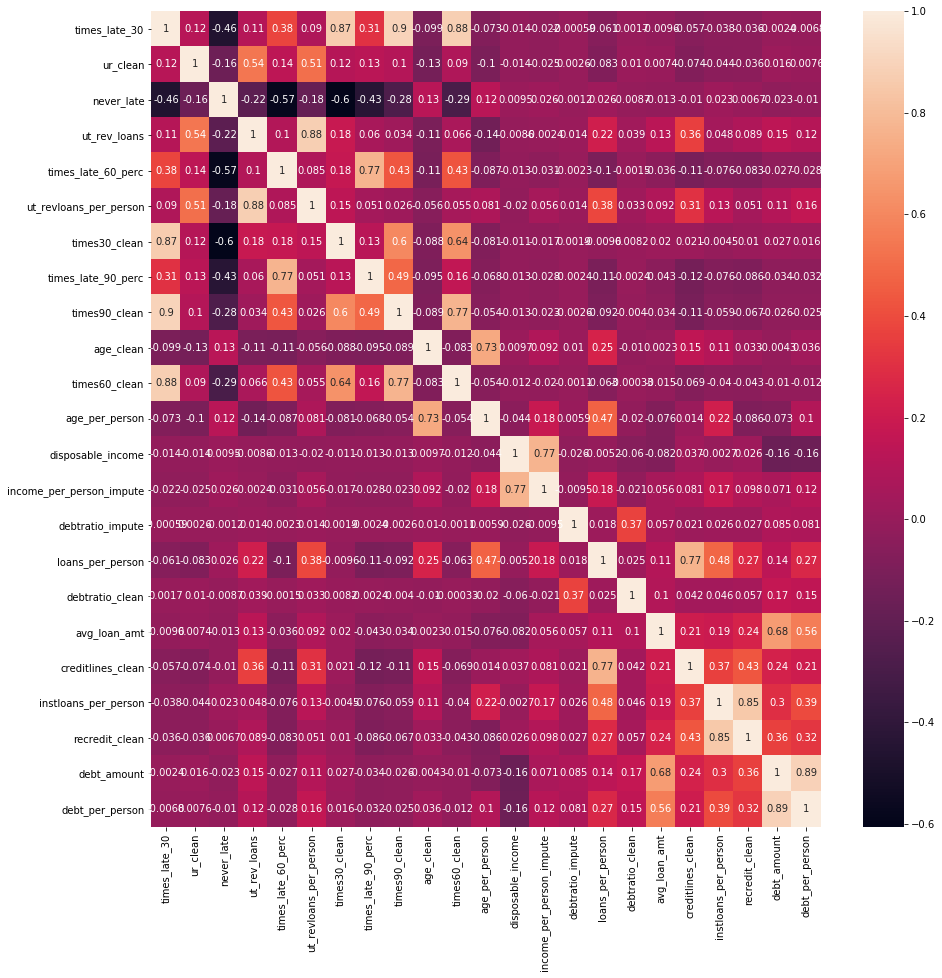

In [23]:
# Calculate correlation matrix for final variable list

corr_matrix = df[final_vars].corr()
fig, ax = plt.subplots(figsize=(15, 15))
sns.heatmap(corr_matrix, annot=True, ax=ax)
plt.show()

In [24]:
# Split data into train/test
x_train, x_test, y_train, y_test = train_test_split(df[final_vars], df[col_target], test_size=.1, random_state=6288)

In [25]:
# Load xgb DMatrix

dtrain = xgb.DMatrix(x_train, label=y_train)
dtest = xgb.DMatrix(x_test, label=y_test)

In [91]:
# Set initial xgb parameters

params = {
'eta':0.06,
'subsample': 0.85,
'max_depth':4,
'min_child_weight': 200,
'colsample_bytree':0.5,
'objective':'binary:logistic',
'eval_metric':'auc'
}

# Set max number of iterations
max_rounds = 1000

# Set early stopping parameter
stop_rounds = 20

In [92]:
# Train final model

model = xgb.train(
    params,
    dtrain,
    num_boost_round = max_rounds,
    evals=[(dtrain,'train'), (dtest, 'Test')],
    early_stopping_rounds = stop_rounds
)

pred_valid = model.predict(dtest)

[0]	train-auc:0.83498	Test-auc:0.82729
Multiple eval metrics have been passed: 'Test-auc' will be used for early stopping.

Will train until Test-auc hasn't improved in 20 rounds.
[1]	train-auc:0.84816	Test-auc:0.84890
[2]	train-auc:0.85075	Test-auc:0.85076
[3]	train-auc:0.85118	Test-auc:0.85000
[4]	train-auc:0.85160	Test-auc:0.85069
[5]	train-auc:0.85239	Test-auc:0.85119
[6]	train-auc:0.85514	Test-auc:0.85402
[7]	train-auc:0.85693	Test-auc:0.85698
[8]	train-auc:0.85721	Test-auc:0.85715
[9]	train-auc:0.85757	Test-auc:0.85707
[10]	train-auc:0.85812	Test-auc:0.85723
[11]	train-auc:0.85802	Test-auc:0.85733
[12]	train-auc:0.85807	Test-auc:0.85728
[13]	train-auc:0.85795	Test-auc:0.85707
[14]	train-auc:0.85886	Test-auc:0.85806
[15]	train-auc:0.85935	Test-auc:0.85859
[16]	train-auc:0.85931	Test-auc:0.85845
[17]	train-auc:0.85929	Test-auc:0.85847
[18]	train-auc:0.86001	Test-auc:0.85986
[19]	train-auc:0.85986	Test-auc:0.85996
[20]	train-auc:0.86000	Test-auc:0.86000
[21]	train-auc:0.86051	Test-a

[200]	train-auc:0.87195	Test-auc:0.86738
[201]	train-auc:0.87196	Test-auc:0.86738
[202]	train-auc:0.87199	Test-auc:0.86738
[203]	train-auc:0.87201	Test-auc:0.86740
[204]	train-auc:0.87205	Test-auc:0.86742
[205]	train-auc:0.87208	Test-auc:0.86746
[206]	train-auc:0.87211	Test-auc:0.86750
[207]	train-auc:0.87212	Test-auc:0.86752
[208]	train-auc:0.87214	Test-auc:0.86754
[209]	train-auc:0.87216	Test-auc:0.86753
[210]	train-auc:0.87218	Test-auc:0.86755
[211]	train-auc:0.87222	Test-auc:0.86756
[212]	train-auc:0.87226	Test-auc:0.86759
[213]	train-auc:0.87227	Test-auc:0.86760
[214]	train-auc:0.87228	Test-auc:0.86761
[215]	train-auc:0.87229	Test-auc:0.86763
[216]	train-auc:0.87230	Test-auc:0.86761
[217]	train-auc:0.87231	Test-auc:0.86766
[218]	train-auc:0.87233	Test-auc:0.86768
[219]	train-auc:0.87236	Test-auc:0.86768
[220]	train-auc:0.87238	Test-auc:0.86767
[221]	train-auc:0.87240	Test-auc:0.86768
[222]	train-auc:0.87242	Test-auc:0.86770
[223]	train-auc:0.87246	Test-auc:0.86773
[224]	train-auc:

[400]	train-auc:0.87527	Test-auc:0.86854
[401]	train-auc:0.87528	Test-auc:0.86853
[402]	train-auc:0.87529	Test-auc:0.86856
[403]	train-auc:0.87531	Test-auc:0.86858
[404]	train-auc:0.87533	Test-auc:0.86857
[405]	train-auc:0.87535	Test-auc:0.86859
[406]	train-auc:0.87536	Test-auc:0.86861
[407]	train-auc:0.87537	Test-auc:0.86859
[408]	train-auc:0.87538	Test-auc:0.86862
[409]	train-auc:0.87539	Test-auc:0.86861
[410]	train-auc:0.87541	Test-auc:0.86863
[411]	train-auc:0.87541	Test-auc:0.86862
[412]	train-auc:0.87542	Test-auc:0.86862
[413]	train-auc:0.87543	Test-auc:0.86860
[414]	train-auc:0.87543	Test-auc:0.86859
[415]	train-auc:0.87546	Test-auc:0.86859
[416]	train-auc:0.87547	Test-auc:0.86860
[417]	train-auc:0.87549	Test-auc:0.86858
[418]	train-auc:0.87551	Test-auc:0.86861
[419]	train-auc:0.87552	Test-auc:0.86862
[420]	train-auc:0.87552	Test-auc:0.86861
[421]	train-auc:0.87553	Test-auc:0.86860
[422]	train-auc:0.87554	Test-auc:0.86860
[423]	train-auc:0.87556	Test-auc:0.86856
[424]	train-auc:

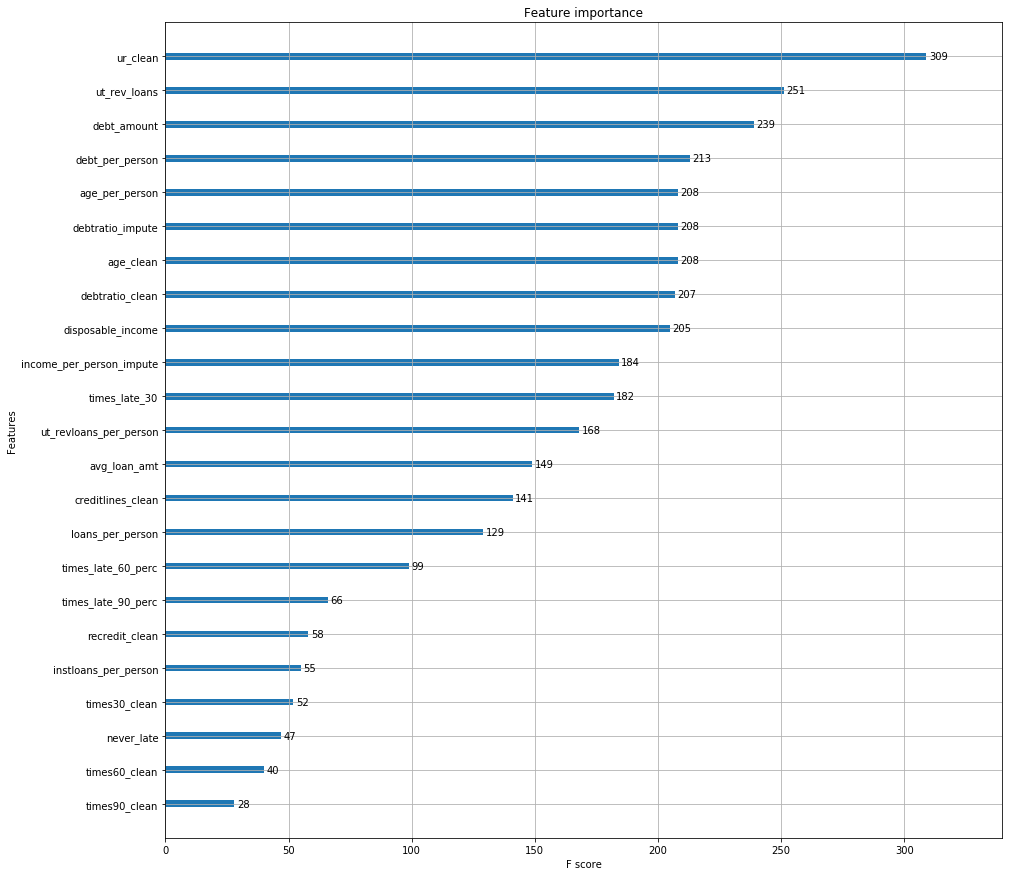

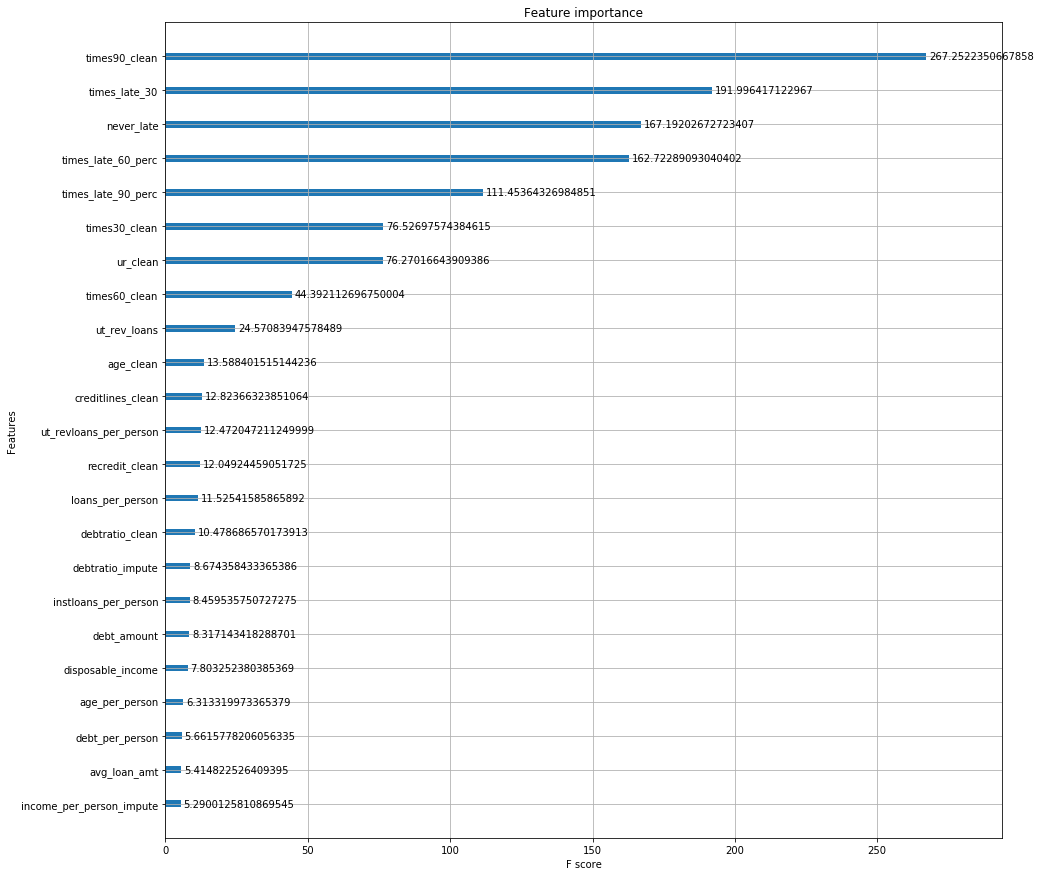

In [93]:
# Get feature importance plot and model gini

# By weight
fig, ax = plt.subplots(figsize=(15, 15))
xgb.plot_importance(model, importance_type='weight', ax=ax)
plt.show()

# By gain
fig, ax = plt.subplots(figsize=(15, 15))
xgb.plot_importance(model, importance_type='gain', ax=ax)
plt.show()

In [94]:
# Model auc

# Calculate auc/gini
auc = roc_auc_score(y_test, pred_valid)
gini = 2*(auc-0.5)

print('auc:', auc)
print('gini:', gini)

auc: 0.868598236754829
gini: 0.7371964735096579


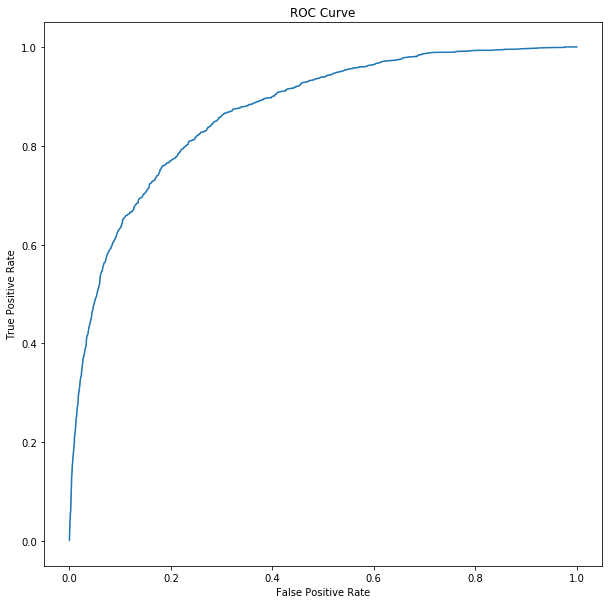

In [95]:
# Plot ROC curve
fpr, tpr, thresholds = roc_curve(y_test, pred_valid)

fig, ax = plt.subplots(figsize=(10, 10))
sns.lineplot(fpr, tpr, ax=ax)
plt.title("ROC Curve")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.show()

Model lift 5%: 7.354965585054081
Model lift 10%: 5.565388397246805
----------------------------------------
Model calibration plot
R2: 0.9978647333975332


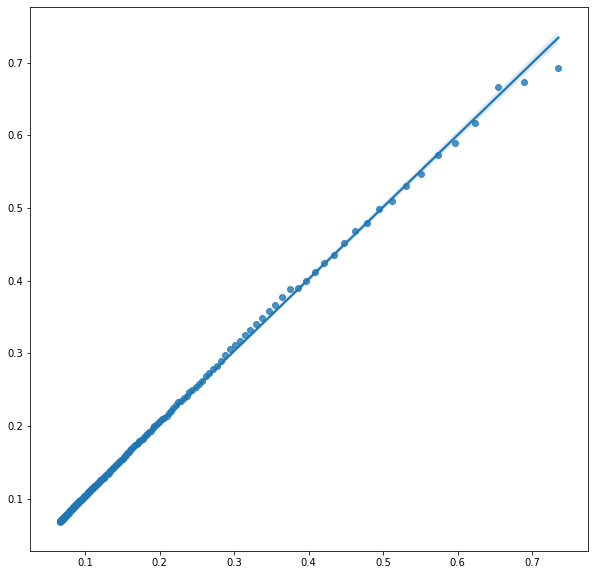

In [96]:
# Model lift

# Combine prediction/result
model_output = pd.DataFrame()
model_output['target'] = y_test
model_output['pred'] = pred_valid

# Define initial list
model_lift = []
avg_score = []
avg_bad_rate = []

# sample bad rate
bad_rate = model_output['target'].mean()

# Calc lift at each percentile
for x in [x/200 for x in range(1,200)]:
    y = 1-x
    quant = model_output['pred'].quantile(y)
    obs = model_output['target'][model_output['pred'] > quant].count()
    model_avg = model_output['pred'][model_output['pred'] > quant].mean()
    x_bad_rate = model_output['target'][model_output['pred'] > quant].mean()
    lift = x_bad_rate/bad_rate
    
    # Append results
    model_lift.append(lift)
    avg_score.append(model_avg)
    avg_bad_rate.append(x_bad_rate)
    
# Put results into dataset
lift_all = pd.DataFrame()
lift_all['percentile'] = [x/200 for x in range(1,200)]
lift_all['model'] = model_lift

print('Model lift 5%:', model_lift[9])
print('Model lift 10%:', model_lift[19])
print('-'*40)
print('Model calibration plot')
print('R2:', r2_score(avg_bad_rate, avg_score))
fig, ax = plt.subplots(figsize=(10, 10))
sns.regplot(avg_score, avg_bad_rate, ax=ax);

In [97]:
# Key variable lift

# Define variables to calculate lift
lift_vars = ['times90_clean','times_late_30','ur_clean']

# Prepare dataset
lift_data = x_test[lift_vars].copy()
lift_data['target'] = y_test

# Loop variables
for var in lift_vars:
    # Define initial list
    var_lift = []
    # Calc lift at each percentile
    for x in [x/200 for x in range(1,200)]:
        y = int(x*lift_data.shape[0])
        temp = lift_data[['target', var]].sort_values(by = var, ascending = False).reset_index().copy()
        obs = temp['target'][0:y].count()
        x_bad_rate = temp['target'][0:y].mean()
        lift = x_bad_rate/bad_rate
        
        # Append results
        var_lift.append(lift)

    # Put results into dataset
    lift_all[var] = var_lift

In [98]:
# Visualise lifts

# Define output style
def highlight_max(s):
    '''
    highlight the maximum in a Series yellow.
    '''
    is_max = s == s.max()
    return ['background-color: yellow' if v else '' for v in is_max]

lift_all.style.apply(highlight_max, axis=1)